# Hydro-LSTM paper

## Outline
1. Introduction
2. Structural Understanding of LSTM
3. Proposed Hydro-LSTM Structure

    Fig1. LSTM and Hydro-LSTM representation
    
4. Experiment Design

    Fig2. Location 
    
5. Results

    Fig3. Comparison of surface responses for 2 catchments
    
            Fig A1a. Comparison of surface responses for 5 catchments
        
            Fig A1b. Comparison of surface responses for 5 next catchments
            
    
    Fig4. Summary of minimum cells and max perfomance.

            Table B1. Comparison between LSTM and Hydro-LSTM
        
            Fig B1. State evolution for one catchment    
    
    
    Fig5. Output gate parameters per catchment for 2 catchments.
    
            Fig C1a. Output gate parameters per catchment for 5 catchments.
        
            Fig C1b. Output gate parameters per catchment for next 5 catchments.
            
    
    Fig6. Lag memory per catchment
    
    Fig7. Spatial distribution of the lag memory
    


    

    

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm
import matplotlib

import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import os
from pathlib import Path
from scipy import stats
import pickle
from scipy.special import expit
from scipy.optimize import curve_fit
from scipy.special import gamma
import torch
from sklearn.cluster import KMeans
import geopandas
import rasterio
from rasterio.plot import show
from IPython.display import Image

from numpy import dot
from numpy.linalg import norm
from sklearn.ensemble import RandomForestRegressor
from zipfile import ZipFile

path = os.getcwd()
import sys
sys.path.insert(0, os.path.abspath(os.path.join(path, os.pardir)) + '/Codes')
from Hydro_LSTM import *
from LSTM import *
from utils import *

# Fig 1 LSTM Representation

In [2]:
Image(url="Fig1.jpg", width=1200, height=300)

# Fig 2 Location map

Reading data

In [3]:
codes = ['11523200','11473900','9223000','9035900','6847900','6353000','2472000','5362000','3173000','1539000'] #MOPEX=['2472000','3173000'] 
lat_codes = [41.11126, 39.70627, 42.11049, 39.79582, 39.76985, 46.09167, 31.70694, 45.30803, 37.26818, 41.07814] 
lon_codes = [-122.70558, -123.32529, -110.70962, -106.03057, -100.10078, -101.33374, -89.40694, -90.95652, -80.70951, -76.43106]

current_path = os.getcwd()
MOPEX = pd.read_csv(current_path + '/MOPEX160_Jiang.csv')

plot

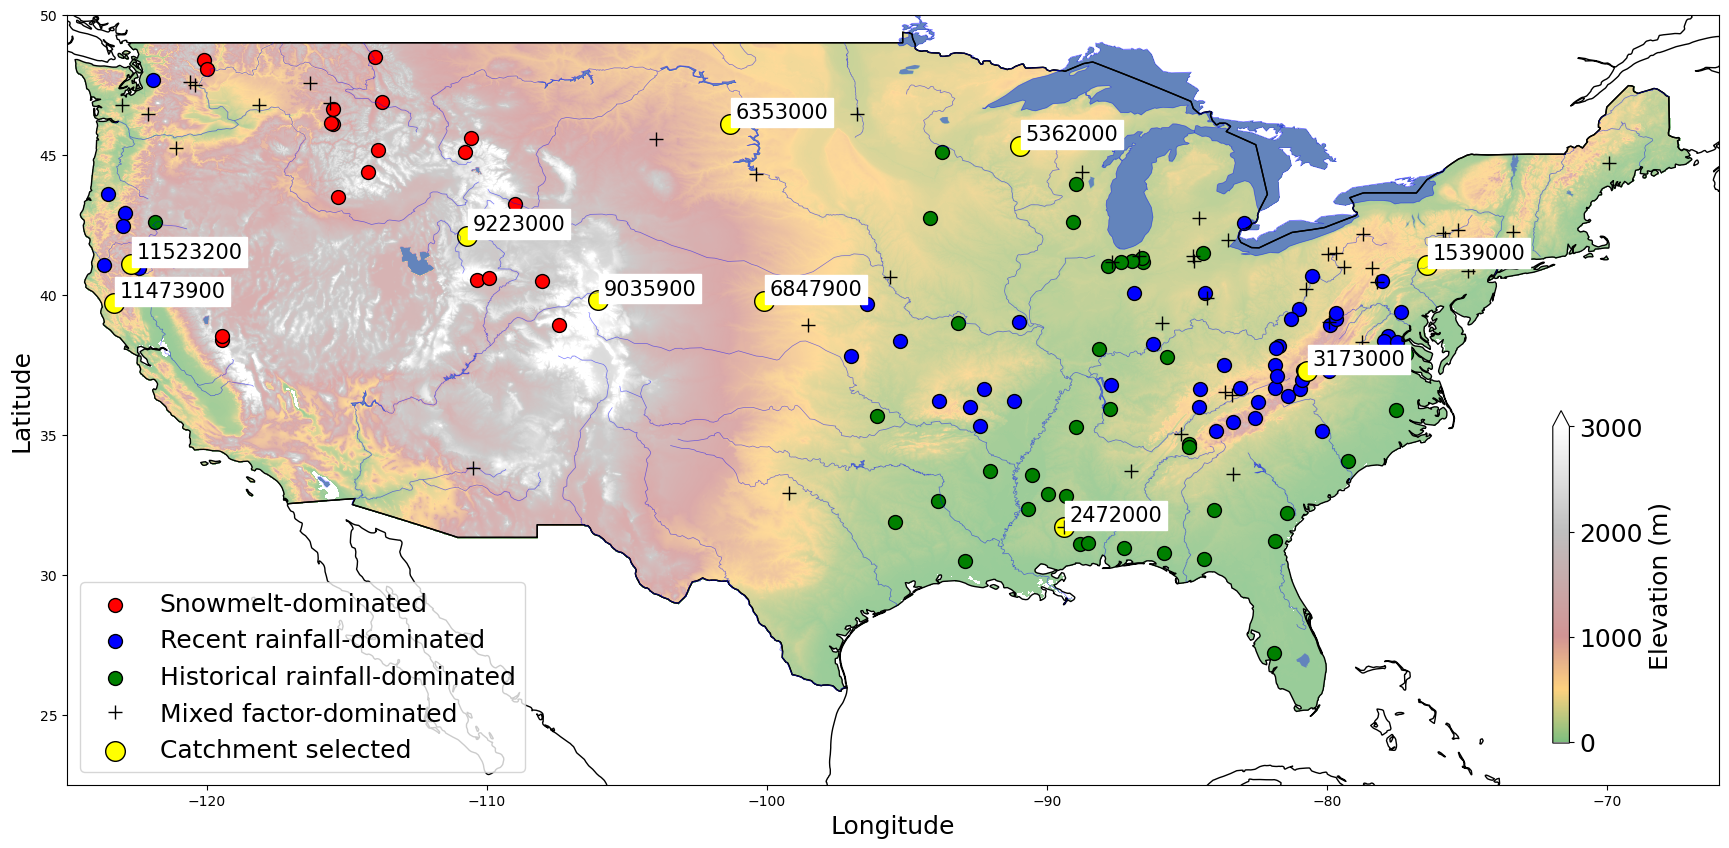

In [4]:
#print(MOPEX)

#df_states = geopandas.read_file(current_path + '/shp/cb_2018_us_state_20m.shp')
df_continent = geopandas.read_file(current_path + '/shp/Americas.shp')
df_drainage_network = geopandas.read_file(current_path + '/shp/Estados_Unidos_Hidrografia.shp')
df_lakes = geopandas.read_file(current_path + '/shp/Estados_Unidos_Lagos.shp')

cvals  = [-11, 0, 500, 1000, 2000,3000]
colors = ["white","green","orange","brown", "gray","white"]
norm_elev=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm_elev,cvals), colors))
cmap_elev = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)





fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(21.45, 10))
plt.rcParams['font.size'] = '18'

#df_states.boundary.plot(color='grey', lw=0.5, ax=ax1)
df_continent.boundary.plot(color='black', lw=1, ax=ax1)
df_drainage_network.plot(color='blue', lw=0.5, ax=ax1, alpha=0.5)
df_lakes.plot(color='blue', lw=0.5, ax=ax1, alpha=0.35)

for i in range(len(codes)):
    ax1.text(lon_codes[i]+0.2,lat_codes[i]+0.2, codes[i], backgroundcolor='white', fontsize=15)
ax1.set_xlabel('Longitude',fontsize=18)
ax1.set_ylabel('Latitude',fontsize=18)
ax1.set_xlim([-125,-66])
ax1.set_ylim([22.5,50])


ax1.scatter(MOPEX.lon[MOPEX.classif=='snow'],MOPEX.lat[MOPEX.classif=='snow'],s=100, color='red', edgecolor='k', label='Snowmelt-dominated')
ax1.scatter(MOPEX.lon[MOPEX.classif=='short'],MOPEX.lat[MOPEX.classif=='short'],s=100, color='blue', edgecolor='k', label='Recent rainfall-dominated')
ax1.scatter(MOPEX.lon[MOPEX.classif=='long'],MOPEX.lat[MOPEX.classif=='long'],s=100, color='green', edgecolor='k', label='Historical rainfall-dominated')
ax1.plot(MOPEX.lon[MOPEX.classif=='mixed'],MOPEX.lat[MOPEX.classif=='mixed'],'k+', label='Mixed factor-dominated', markersize=10)
ax1.scatter(lon_codes,lat_codes, s=200, color='yellow', edgecolor='k', label='Catchment selected')

ax1.legend(loc=3)


fp = current_path +'/elevation.zip'
with ZipFile(fp, 'r') as f:
    f.extractall()

fp = current_path +'/elevation.tif'    
img = rasterio.open(fp, 'r')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm_elev, cmap=cmap_elev), ax=ax1, fraction=0.01,anchor=(0,0.1), pad=-0.1 , extend='max', alpha=0.5)
cbar.set_label('Elevation (m)', rotation=90)

im1 = show((img, 1), cmap=cmap_elev, norm=norm_elev, alpha=0.4)

path = current_path + '/Fig2.jpg'
fig.savefig(path,  bbox_inches="tight")

# Fig3. Comparison of surface responses


In [5]:
current_path = os.getcwd()
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Results/'

codes = [11473900,9035900] 
cells = [1,2,3,4,8,16] 
Lags = [2,4,8,16,32,64,128,256]

cells_exp = [1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,16,16,16,16,16,16,16,16]
lags_exp = [2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256]

median_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
q25_75_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
mean_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
std_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
Results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
p_values_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell','KGE','p_value'])

median_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
q25_75_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
mean_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
std_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
Results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
p_values_Hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'KGE', 'p_value'])

best_lag_hydro = [32,256]
best_cell_hydro = [1,1]


i=0
j=0
z=0
for code in tqdm(codes):
    max_Hydro = -999
    max_LSTM = -999
    for cell in cells:
        for lag in Lags:
            full_path_LSTM = path + 'LSTM/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_lstm_summary.csv'
            df_LSTM = pd.read_csv(full_path_LSTM)
            full_path_Hydro = path + 'hydro/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
            df_Hydro = pd.read_csv(full_path_Hydro)
            max_Hydro = max(max_Hydro,df_Hydro.KGE.mean())
            
            i = i + 1

            summary = df_LSTM.describe()
            median_results_LSTM.loc[i,'code'] = code
            median_results_LSTM.loc[i][1:10] = summary.loc['50%'][1:10]
            mean_results_LSTM.loc[i,'code'] = code
            mean_results_LSTM.loc[i][1:10] = summary.loc['mean'][1:10]
            q25_75_results_LSTM.loc[i,'code'] = code
            q25_75_results_LSTM.loc[i][1:10] = summary.loc['75%'][1:10] - summary.loc['25%'][1:10]
            q25_75_results_LSTM.loc[i,'lag'] = lag
            q25_75_results_LSTM.loc[i,'batch'] = 8
            q25_75_results_LSTM.loc[i,'cell'] = cell
            std_results_LSTM.loc[i,'code'] = code
            std_results_LSTM.loc[i][1:10] = summary.loc['std'][1:10]
            std_results_LSTM.loc[i,'lag'] = lag
            std_results_LSTM.loc[i,'batch'] = 8
            std_results_LSTM.loc[i,'cell'] = cell
            max_LSTM = max(max_LSTM,summary.KGE.mean())
            df_LSTM['code'] = code
            Results_LSTM = pd.concat([Results_LSTM,df_LSTM], ignore_index=True) #Results_LSTM.append(df_LSTM, ignore_index=True)

            
            summary = df_Hydro.describe()
            median_results_hydro.loc[i,'code'] = code
            median_results_hydro.loc[i][1:10] = summary.loc['50%'][1:10]
            mean_results_hydro.loc[i,'code'] = code
            mean_results_hydro.loc[i][1:10] = summary.loc['mean'][1:10]
            q25_75_results_hydro.loc[i,'code'] = code
            q25_75_results_hydro.loc[i][1:10] = summary.loc['75%'][1:10] - summary.loc['25%'][1:10]
            q25_75_results_hydro.loc[i,'lag'] = lag
            q25_75_results_hydro.loc[i,'batch'] = 8
            q25_75_results_hydro.loc[i,'cell'] = cell
            std_results_hydro.loc[i,'code'] = code
            std_results_hydro.loc[i][1:10] = summary.loc['std'][1:10]
            std_results_hydro.loc[i,'lag'] = lag
            std_results_hydro.loc[i,'batch'] = 8
            std_results_hydro.loc[i,'cell'] = cell
            df_Hydro['code'] = code
            Results_hydro = pd.concat([Results_hydro, df_Hydro],ignore_index=True) #Results_hydro.append(df_Hydro, ignore_index=True)

    column = mean_results_LSTM.KGE[mean_results_LSTM.code == code]
    column = column.values
    max_value = column.max()
    max_index = np.argmax(column)
    best_lag = lags_exp[max_index]
    best_cell = cells_exp[max_index]


    column = mean_results_hydro[mean_results_LSTM.code == code].KGE
    column = column[:8].values
    max_value = column.max()
    max_index = np.argmax(column)
        

    column = mean_results_hydro[mean_results_hydro.code == code].KGE
    column = column[:8].values
    max_value = column.max()
    max_index = np.argmax(column)

    full_path_best = path + '/hydro/'+ str(code) + '_C' + str(best_cell_hydro[z]) + '_L' + str(best_lag_hydro[z]) + '_hydro_summary.csv'
    summary_best_hydro = pd.read_csv(full_path_best)
    
    for cell in cells:
        for lag in Lags:
            full_path_LSTM = path + '/LSTM/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_lstm_summary.csv'
            df_LSTM = pd.read_csv(full_path_LSTM)
            full_path_hydro = path + '/hydro/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
            df_Hydro = pd.read_csv(full_path_hydro)
            
            df_LSTM['code'] = code
            df_Hydro['code'] = code
            
            j = j + 1
            p_values_LSTM.loc[j,'code'] = code
            p_values_LSTM.loc[j,'lag'] = lag
            p_values_LSTM.loc[j,'cell'] = cell
            p_values_LSTM.loc[j,'batch'] = 8
            p_values_LSTM.loc[j,'KGE'] = df_LSTM.KGE.mean()
            
            p_values_Hydro.loc[j,'code'] = code
            p_values_Hydro.loc[j,'lag'] = lag
            p_values_Hydro.loc[j,'cell'] = cell
            p_values_Hydro.loc[j,'batch'] = 8
            p_values_Hydro.loc[j,'KGE'] = df_Hydro.KGE.mean()
            
            
            _, p_values_LSTM.loc[j,'p_value'] = stats.ttest_ind(summary_best_hydro.KGE, df_LSTM.KGE, equal_var=False)
            _, p_values_Hydro.loc[j,'p_value'] = stats.ttest_ind(summary_best_hydro.KGE, df_Hydro.KGE, equal_var=False)       
    z = z +1

            
         
            
         
            
            
            
            
 

100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


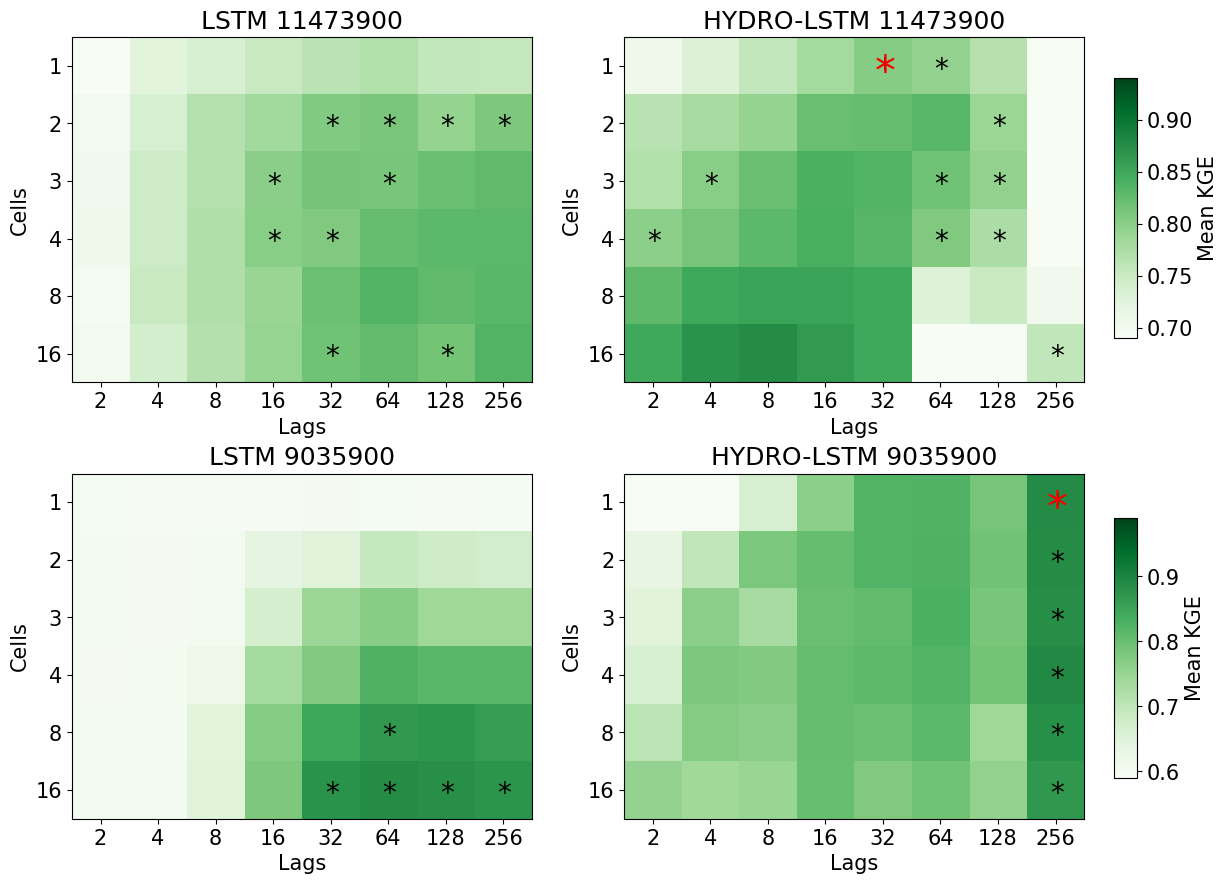

In [6]:

orig_map=plt.cm.get_cmap('Greens') #summer
reversed_map = orig_map # orig_map.reversed()
cmap=reversed_map

plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = '15'
plt.title('Performance comparison (Mean)')
codes = [11473900,11473900,9035900,9035900]
equif = pd.DataFrame(columns=['code','lag', 'cell','model'])

cells = [1,2,3,4,8,16] 
Lags = [2,4,8,16,32,64,128,256]

p_value_thresold = {11523200:0.1,11473900:0.1,9223000:0.1,9035900:0.1,6847900:0.1,6353000:0.1,2472000:0.1,5362000:0.1,3173000:0.1,1539000:0.1}

array = np.empty((6,8))
pos_range  = np.empty((6,8))
i = 1
j = 0
type_model = -1  #-1=LSTM 1=Hydro-LSTM
for code in codes:
    for cell in range(len(cells)):
        for lag in range(len(Lags)):
            if type_model ==-1:
                selection_LSTM = mean_results_LSTM.iloc[:][mean_results_LSTM.code==code]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.cell==cells[cell]]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.lag==Lags[lag]]
                array[cell, lag] = selection_LSTM.KGE
                title = 'LSTM '
                max_array = array.max() + 0.1 
                min_array = array.min()
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_LSTM[p_values_LSTM.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False
            else:                      
                selection_hydro = mean_results_hydro.iloc[:][mean_results_hydro.code==code]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.cell==cells[cell]]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.lag==Lags[lag]]
                array[cell, lag] = selection_hydro.KGE
                title = 'HYDRO-LSTM '
                
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_Hydro[p_values_Hydro.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False
  
    plt.subplot(2,2,i)      

    X, Y = np.meshgrid(Lags, cells)
    levels = np.arange(0,1,0.05)
    
    im = plt.imshow(array, cmap=cmap, vmin=round(min_array,2), vmax=round(max_array,2))
    
    for x in range(6):
        for y in range(8):
            if pos_range[x,y]:
                plt.text(y-0.1,x+0.2,'*', fontsize=20) #, color='red'
                equif.loc[j,'code'] = code
                equif.loc[j,'cell'] = cells[x]
                equif.loc[j,'lag'] = Lags[y]
                if type_model ==-1:
                    equif.loc[j,'model'] = 'LSTM'
                else:
                    equif.loc[j,'model'] = 'Hydro-LSTM'                       
                j = j + 1
       
    plt.title(title + str(code))
    plt.xlabel('Lags')
    plt.ylabel('Cells')
    plt.xticks([0,1,2,3,4,5,6,7], Lags)
    plt.yticks([0,1,2,3,4,5], cells)
       
    if type_model ==1:
        z = int(i/2) - 1
        plt.text(np.log2(best_lag_hydro[z])-1-0.15,np.log2(best_cell_hydro[z])+0.32,'*', fontsize=30, color='red')

        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        if i>3:
            cax = plt.axes([0.82, 0.15, 0.015, 0.26])
        else:      
            cax = plt.axes([0.82, 0.59, 0.015, 0.26])

        cbar = plt.colorbar(cax=cax)       
        cbar.set_label('Mean KGE', rotation=90)
        
    
    i= i + 1
    type_model = type_model * (-1)   
    

plt.savefig('Fig3.jpg',  bbox_inches="tight")


# Fig A1 KGE performance for others catchments 

In [7]:
current_path = os.getcwd()
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Results/'


codes = [11523200,11473900,9223000,9035900,6847900,6353000,2472000,5362000,3173000,1539000] 
cells = [1,2,3,4,8,16] 
Lags = [2,4,8,16,32,64,128,256]

cells_exp = [1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,16,16,16,16,16,16,16,16]
lags_exp = [2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256,2,4,8,16,32,64,128,256]

median_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
q25_75_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
mean_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
std_results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
Results_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
p_values_LSTM = pd.DataFrame(columns=['code','lag', 'batch', 'cell','KGE','p_value'])

median_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
q25_75_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
mean_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
std_results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
Results_hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'RMSE', 'MAE', 'R2', 'CC', 'Bias', 'KGE'])
p_values_Hydro = pd.DataFrame(columns=['code','lag', 'batch', 'cell', 'KGE', 'p_value'])

best_lag_hydro = [256,32,64,256,4,256,256,32,16,8]
best_cell_hydro = [2,1,1,1,2,1,1,1,1,1]

i=0
j=0
z=0
for code in tqdm(codes):
    max_Hydro = -999
    max_LSTM = -999
    for cell in cells:
        for lag in Lags:
            full_path_LSTM = path + 'LSTM/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_lstm_summary.csv'
            df_LSTM = pd.read_csv(full_path_LSTM)
            full_path_Hydro = path + 'hydro/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
            df_Hydro = pd.read_csv(full_path_Hydro)
            max_Hydro = max(max_Hydro,df_Hydro.KGE.mean())

            i = i + 1
            
            summary = df_LSTM.describe()
            median_results_LSTM.loc[i,'code'] = code
            median_results_LSTM.loc[i][1:10] = summary.loc['50%'][1:10]
            mean_results_LSTM.loc[i,'code'] = code
            mean_results_LSTM.loc[i][1:10] = summary.loc['mean'][1:10]
            q25_75_results_LSTM.loc[i,'code'] = code
            q25_75_results_LSTM.loc[i][1:10] = summary.loc['75%'][1:10] - summary.loc['25%'][1:10]
            q25_75_results_LSTM.loc[i,'lag'] = lag
            q25_75_results_LSTM.loc[i,'batch'] = 8
            q25_75_results_LSTM.loc[i,'cell'] = cell
            std_results_LSTM.loc[i,'code'] = code
            std_results_LSTM.loc[i][1:10] = summary.loc['std'][1:10]
            std_results_LSTM.loc[i,'lag'] = lag
            std_results_LSTM.loc[i,'batch'] = 8
            std_results_LSTM.loc[i,'cell'] = cell
            max_LSTM = max(max_LSTM,summary.KGE.mean())
            df_LSTM['code'] = code
            Results_LSTM = pd.concat([Results_LSTM,df_LSTM], ignore_index=True) #Results_LSTM.append(df_LSTM, ignore_index=True)
           
            summary = df_Hydro.describe()
            median_results_hydro.loc[i,'code'] = code
            median_results_hydro.loc[i][1:10] = summary.loc['50%'][1:10]
            mean_results_hydro.loc[i,'code'] = code
            mean_results_hydro.loc[i][1:10] = summary.loc['mean'][1:10]
            q25_75_results_hydro.loc[i,'code'] = code
            q25_75_results_hydro.loc[i][1:10] = summary.loc['75%'][1:10] - summary.loc['25%'][1:10]
            q25_75_results_hydro.loc[i,'lag'] = lag
            q25_75_results_hydro.loc[i,'batch'] = 8
            q25_75_results_hydro.loc[i,'cell'] = cell
            std_results_hydro.loc[i,'code'] = code
            std_results_hydro.loc[i][1:10] = summary.loc['std'][1:10]
            std_results_hydro.loc[i,'lag'] = lag
            std_results_hydro.loc[i,'batch'] = 8
            std_results_hydro.loc[i,'cell'] = cell
            df_Hydro['code'] = code
            Results_hydro = pd.concat([Results_hydro, df_Hydro],ignore_index=True) #Results_hydro.append(df_Hydro, ignore_index=True)

    column = mean_results_LSTM.KGE[mean_results_LSTM.code == code]
    column = column.values
    max_value = column.max()
    max_index = np.argmax(column)
    best_lag = lags_exp[max_index]
    best_cell = cells_exp[max_index]

    column = mean_results_hydro[mean_results_LSTM.code == code].KGE
    column = column[:8].values
    max_value = column.max()
    max_index = np.argmax(column)        

    column = mean_results_hydro[mean_results_hydro.code == code].KGE
    column = column[:8].values
    max_value = column.max()
    max_index = np.argmax(column)
  
    full_path_best = path + '/hydro/'+ str(code) + '_C' + str(best_cell_hydro[z]) + '_L' + str(best_lag_hydro[z]) + '_hydro_summary.csv'
    summary_best_hydro = pd.read_csv(full_path_best)
    
    for cell in cells:
        for lag in Lags:
            full_path_LSTM = path + '/LSTM/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_lstm_summary.csv'
            df_LSTM = pd.read_csv(full_path_LSTM)
            full_path_hydro = path + '/hydro/'+ str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
            df_Hydro = pd.read_csv(full_path_hydro)
            
            df_LSTM['code'] = code
            df_Hydro['code'] = code
            
            j = j + 1
            p_values_LSTM.loc[j,'code'] = code
            p_values_LSTM.loc[j,'lag'] = lag
            p_values_LSTM.loc[j,'cell'] = cell
            p_values_LSTM.loc[j,'batch'] = 8
            p_values_LSTM.loc[j,'KGE'] = df_LSTM.KGE.mean()
            
            p_values_Hydro.loc[j,'code'] = code
            p_values_Hydro.loc[j,'lag'] = lag
            p_values_Hydro.loc[j,'cell'] = cell
            p_values_Hydro.loc[j,'batch'] = 8
            p_values_Hydro.loc[j,'KGE'] = df_Hydro.KGE.mean()
                         
            _, p_values_LSTM.loc[j,'p_value'] = stats.ttest_ind(summary_best_hydro.KGE, df_LSTM.KGE, equal_var=False)
            _, p_values_Hydro.loc[j,'p_value'] = stats.ttest_ind(summary_best_hydro.KGE, df_Hydro.KGE, equal_var=False)       
    z = z +1

            
         
            
            
           

100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


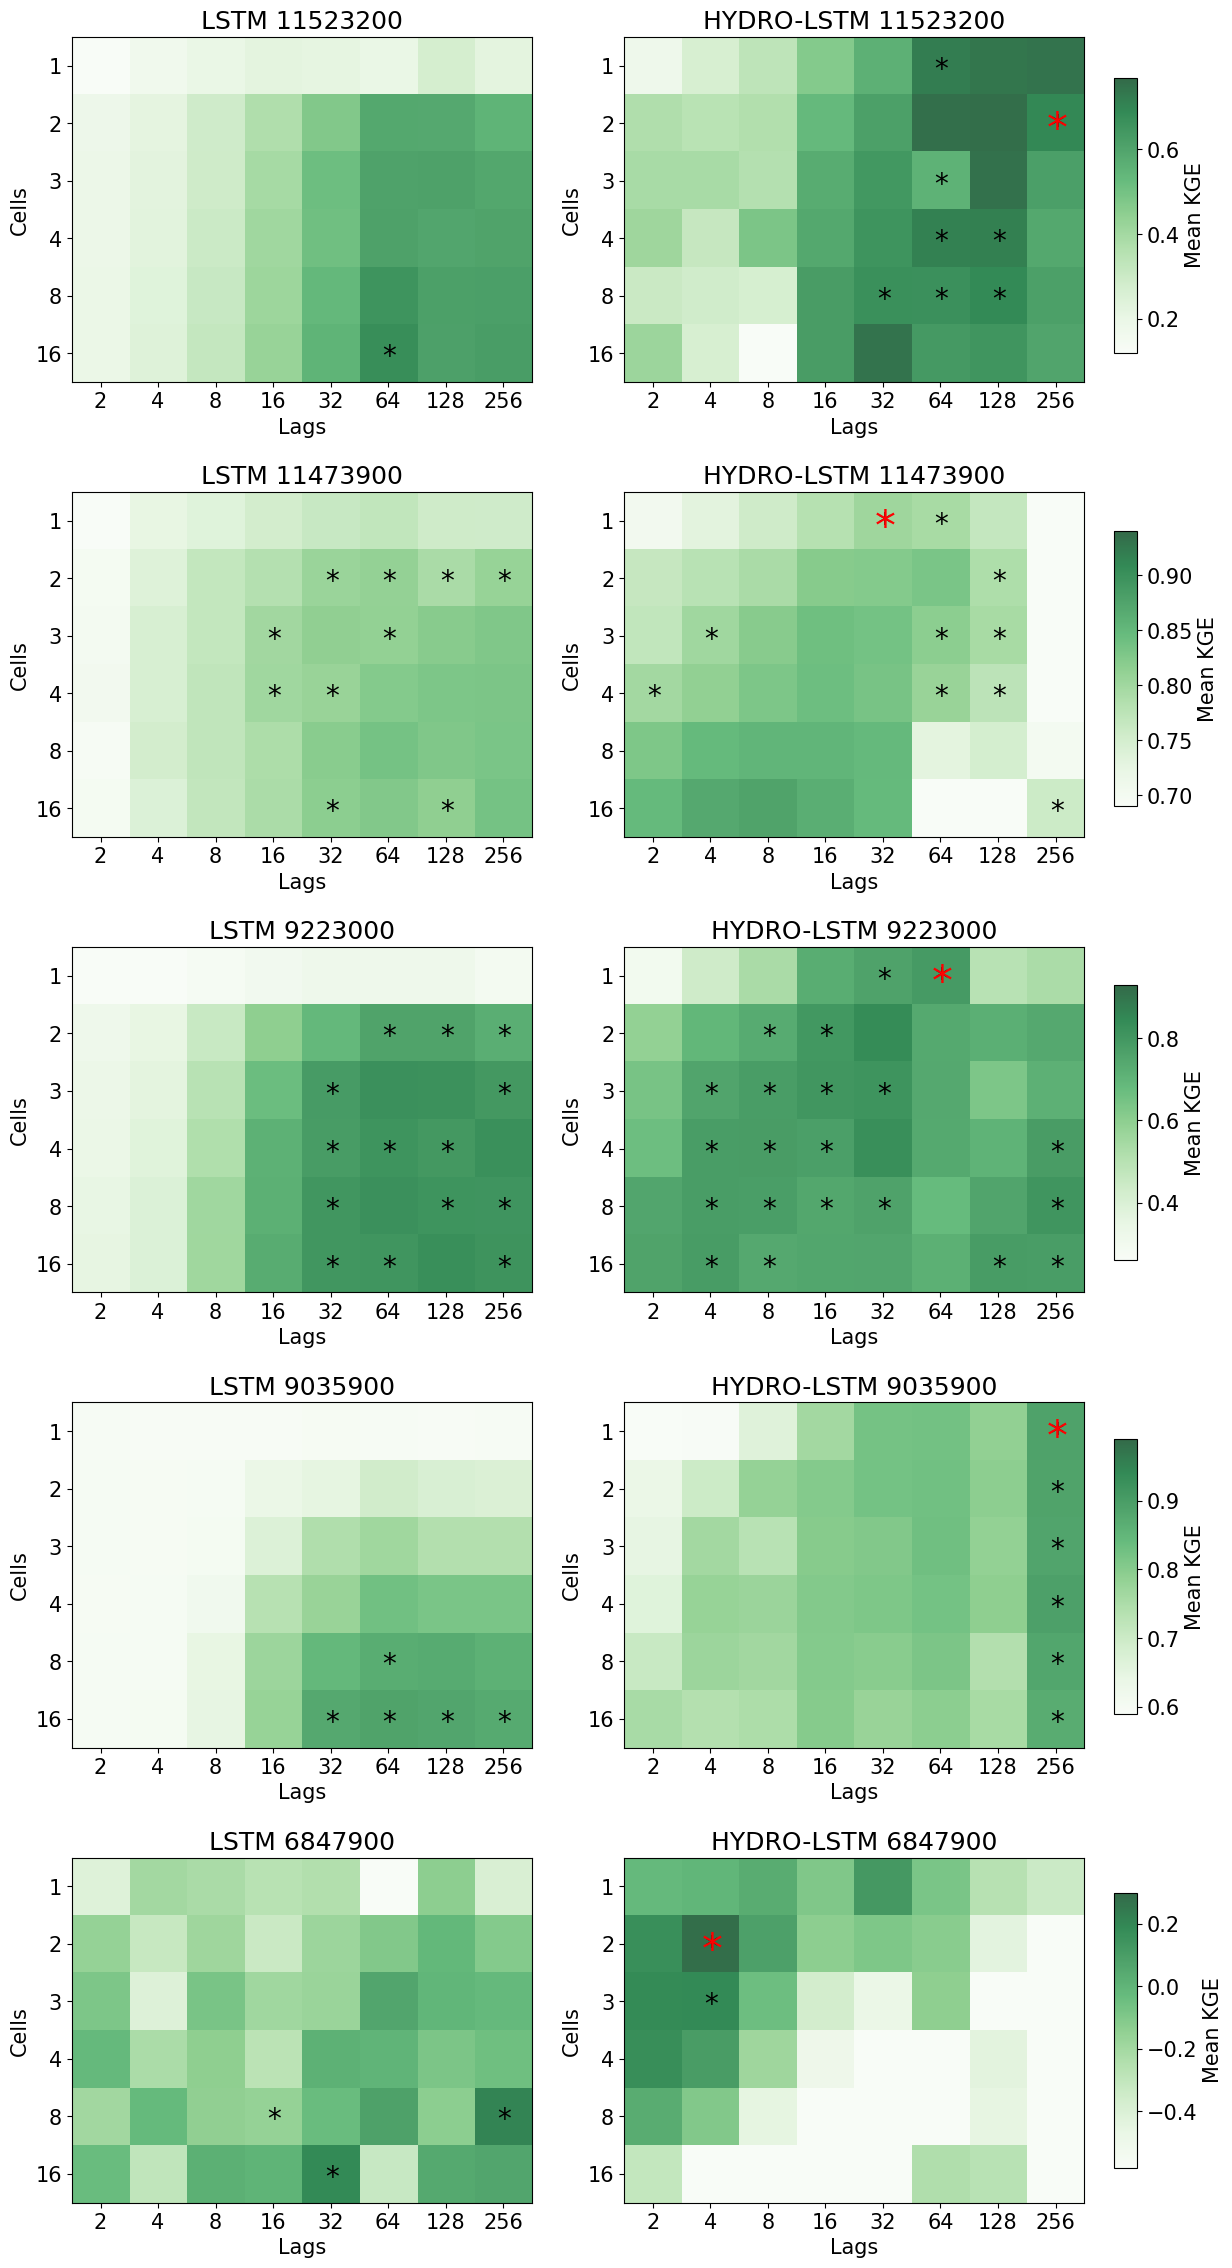

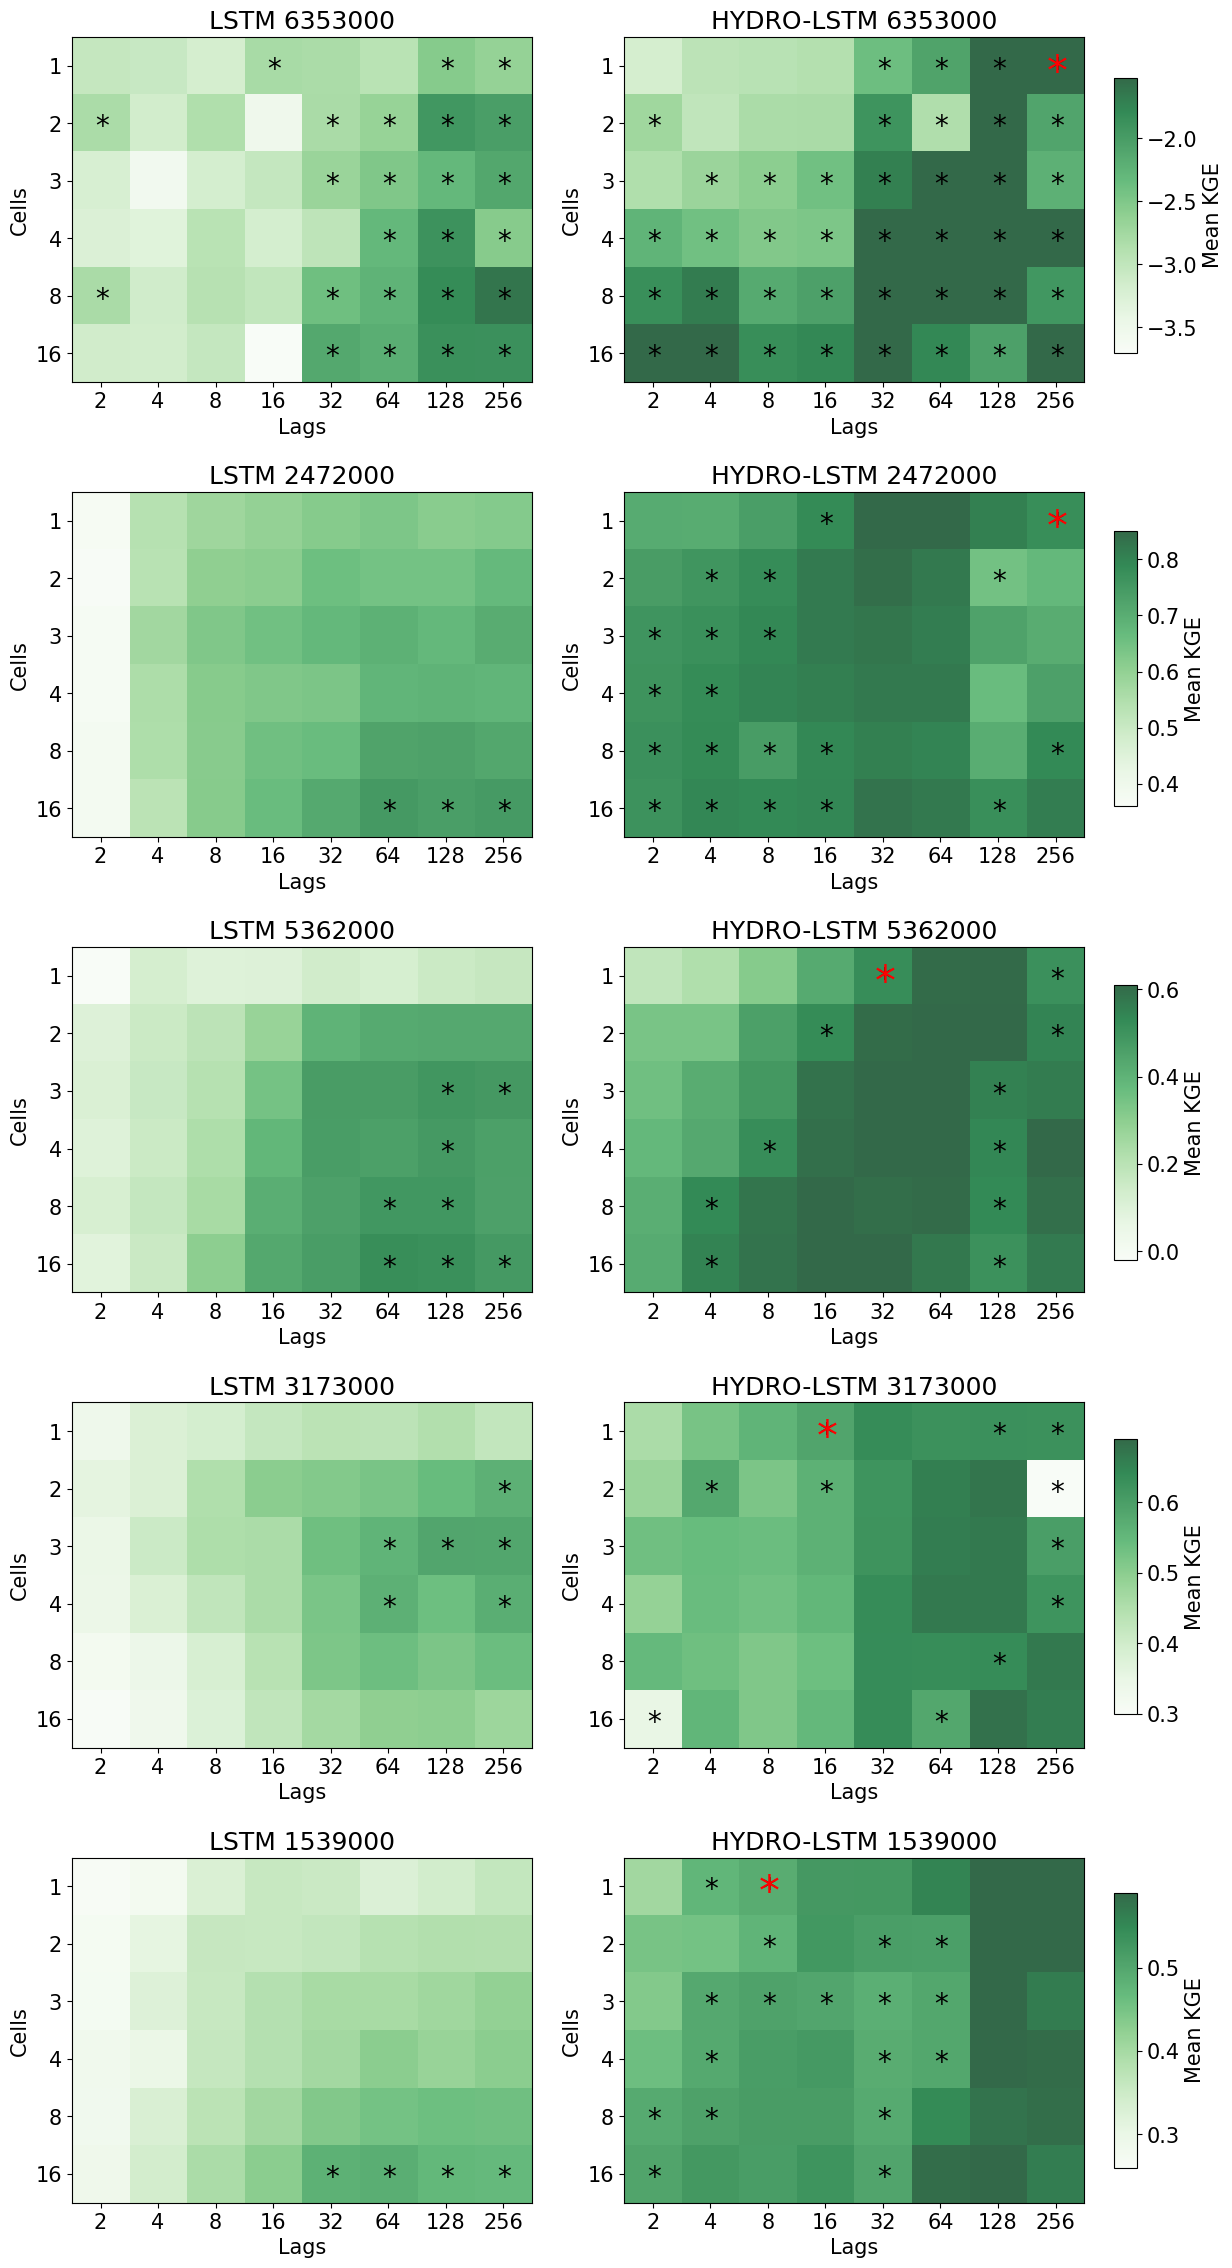

In [8]:

orig_map=plt.cm.get_cmap('Greens') #summer
reversed_map = orig_map # orig_map.reversed()

plt.figure(figsize=(15,27.5))
plt.rcParams['font.size'] = '15'
plt.title('Performance comparison (Mean)')

codes = [11523200,11523200, 11473900,11473900,9223000,9223000,9035900,9035900,6847900,6847900]
p_value_thresold = {11523200:0.1,11473900:0.1,9223000:0.1,9035900:0.1,6847900:0.1,6353000:0.1,2472000:0.1,5362000:0.1,3173000:0.1,1539000:0.1}
best_lag_hydro = [256,32,64,256,4]
best_cell_hydro = [2,1,1,1,2]

equif = pd.DataFrame(columns=['code','lag', 'cell','model'])
cells = [1,2,3,4,8,16] 
Lags = [2,4,8,16,32,64,128,256]

array = np.empty((6,8))
pos_range  = np.empty((6,8))
i = 1
j = 0
type_model = -1  #-1=LSTM 1=Hydro-LSTM
for code in codes:
    for cell in range(len(cells)):
        for lag in range(len(Lags)):
            if type_model ==-1:
                selection_LSTM = mean_results_LSTM.iloc[:][mean_results_LSTM.code==code]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.cell==cells[cell]]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.lag==Lags[lag]]
                array[cell, lag] = selection_LSTM.KGE
                title = 'LSTM '
                max_array = array.max() + 0.1 
                min_array = array.min()
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_LSTM[p_values_LSTM.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False
            else:                      
                selection_hydro = mean_results_hydro.iloc[:][mean_results_hydro.code==code]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.cell==cells[cell]]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.lag==Lags[lag]]
                array[cell, lag] = selection_hydro.KGE
                title = 'HYDRO-LSTM '
                
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_Hydro[p_values_Hydro.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False

             
    plt.subplot(int(len(codes)*0.5),2,i)
    cmap=reversed_map
    alpha=0.8
    

    X, Y = np.meshgrid(Lags, cells)
    levels = np.arange(0,1,0.05)
       
    im = plt.imshow(array, cmap=cmap, vmin=round(min_array,2), vmax=round(max_array,2), alpha=alpha)
 
    for x in range(6):
        for y in range(8):
            if pos_range[x,y]:
                plt.text(y-0.1,x+0.2,'*', fontsize=20) #, color='red'
                equif.loc[j,'code'] = code
                equif.loc[j,'cell'] = cells[x]
                equif.loc[j,'lag'] = Lags[y]
                if type_model ==-1:
                    equif.loc[j,'model'] = 'LSTM'
                else:
                    equif.loc[j,'model'] = 'Hydro-LSTM'                       
                j = j + 1
                
    
       
    plt.title(title + str(code))
    plt.xlabel('Lags')
    plt.ylabel('Cells')
    plt.xticks([0,1,2,3,4,5,6,7], Lags)
    plt.yticks([0,1,2,3,4,5], cells)  

    if type_model ==1:
        z = int(i/2) - 1
        plt.text(np.log2(best_lag_hydro[z])-1-0.15,np.log2(best_cell_hydro[z])+0.32,'*', fontsize=30, color='red')
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        if i==10:
            cax = plt.axes([0.82, 0.119, 0.015, 0.10])
        if i==8:      
            cax = plt.axes([0.82, 0.284, 0.015, 0.10])
        if i==6:      
            cax = plt.axes([0.82, 0.449, 0.015, 0.10])
        if i==4:      
            cax = plt.axes([0.82, 0.614, 0.015, 0.10])
        if i==2:      
            cax = plt.axes([0.82, 0.779, 0.015, 0.10])
        cbar = plt.colorbar(cax=cax)       
        cbar.set_label('Mean KGE', rotation=90)
        
    i= i + 1
    type_model = type_model * (-1)         
    
plt.savefig('FigA1_a.jpg',  bbox_inches="tight")



plt.figure(figsize=(15,27.5))
plt.rcParams['font.size'] = '15'
plt.title('Performance comparison (Mean)')

codes = [6353000,6353000,2472000,2472000,5362000,5362000,3173000,3173000,1539000,1539000]
p_value_thresold = {11523200:0.1,11473900:0.1,9223000:0.1,9035900:0.1,6847900:0.1,6353000:0.1,2472000:0.1,5362000:0.1,3173000:0.1,1539000:0.1}
best_lag_hydro = [256,256,32,16,8]
best_cell_hydro = [1,1,1,1,1]

equif = pd.DataFrame(columns=['code','lag', 'cell','model'])
cells = [1,2,3,4,8,16] 
Lags = [2,4,8,16,32,64,128,256]

array = np.empty((6,8))
pos_range  = np.empty((6,8))
i = 1
j = 0
type_model = -1  #-1=LSTM 1=Hydro-LSTM
for code in codes:
    for cell in range(len(cells)):
        for lag in range(len(Lags)):
            if type_model ==-1:
                selection_LSTM = mean_results_LSTM.iloc[:][mean_results_LSTM.code==code]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.cell==cells[cell]]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.lag==Lags[lag]]
                array[cell, lag] = selection_LSTM.KGE
                title = 'LSTM '
                max_array = array.max() + 0.1 
                min_array = array.min()
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_LSTM[p_values_LSTM.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False
            else:                      
                selection_hydro = mean_results_hydro.iloc[:][mean_results_hydro.code==code]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.cell==cells[cell]]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.lag==Lags[lag]]
                array[cell, lag] = selection_hydro.KGE
                title = 'HYDRO-LSTM '
                
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_Hydro[p_values_Hydro.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False
  
 
    plt.subplot(int(len(codes)*0.5),2,i)
    cmap=reversed_map
    alpha=0.8    

    X, Y = np.meshgrid(Lags, cells)
    levels = np.arange(0,1,0.05)
    
    im = plt.imshow(array, cmap=cmap, vmin=round(min_array,2), vmax=round(max_array,2), alpha=alpha)
   
    for x in range(6):
        for y in range(8):
            if pos_range[x,y]:
                plt.text(y-0.1,x+0.2,'*', fontsize=20) #, color='red'
                equif.loc[j,'code'] = code
                equif.loc[j,'cell'] = cells[x]
                equif.loc[j,'lag'] = Lags[y]
                if type_model ==-1:
                    equif.loc[j,'model'] = 'LSTM'
                else:
                    equif.loc[j,'model'] = 'Hydro-LSTM'                       
                j = j + 1
                

    plt.title(title + str(code))
    plt.xlabel('Lags')
    plt.ylabel('Cells')
    plt.xticks([0,1,2,3,4,5,6,7], Lags)
    plt.yticks([0,1,2,3,4,5], cells)

    if type_model ==1:
        z = int(i/2) - 1
        plt.text(np.log2(best_lag_hydro[z])-1-0.15,np.log2(best_cell_hydro[z])+0.32,'*', fontsize=30, color='red')
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        if i==10:
            cax = plt.axes([0.82, 0.119, 0.015, 0.10])
        if i==8:      
            cax = plt.axes([0.82, 0.284, 0.015, 0.10])
        if i==6:      
            cax = plt.axes([0.82, 0.449, 0.015, 0.10])
        if i==4:      
            cax = plt.axes([0.82, 0.614, 0.015, 0.10])
        if i==2:      
            cax = plt.axes([0.82, 0.779, 0.015, 0.10])
        cbar = plt.colorbar(cax=cax)       
        cbar.set_label('Mean KGE', rotation=90)
        
    
    i= i + 1
    type_model = type_model * (-1)         
    
plt.savefig('FigA1_b.jpg',  bbox_inches="tight")


In [9]:
codes = [11523200,11523200, 11473900,11473900,9223000,9223000,9035900,9035900,6847900,6847900,6353000,6353000,2472000,2472000,5362000,5362000,3173000,3173000,1539000,1539000]
p_value_thresold = {11523200:0.1,11473900:0.1,9223000:0.1,9035900:0.1,6847900:0.1,6353000:0.1,2472000:0.1,5362000:0.1,3173000:0.1,1539000:0.1}
best_lag_hydro = [256,256,32,16,8]
best_cell_hydro = [1,1,1,1,1]

equif = pd.DataFrame(columns=['code','lag', 'cell','model'])
cells = [1,2,3,4,8,16] 
Lags = [2,4,8,16,32,64,128,256]

array = np.empty((6,8))
pos_range  = np.empty((6,8))
i = 1
j = 0
type_model = -1  #-1=LSTM 1=Hydro-LSTM
for code in codes:
    for cell in range(len(cells)):
        for lag in range(len(Lags)):
            if type_model ==-1:
                selection_LSTM = mean_results_LSTM.iloc[:][mean_results_LSTM.code==code]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.cell==cells[cell]]
                selection_LSTM = selection_LSTM.iloc[:][selection_LSTM.lag==Lags[lag]]
                array[cell, lag] = selection_LSTM.KGE
                title = 'LSTM '
                max_array = array.max() + 0.1 
                min_array = array.min()
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_LSTM[p_values_LSTM.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False
            else:                      
                selection_hydro = mean_results_hydro.iloc[:][mean_results_hydro.code==code]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.cell==cells[cell]]
                selection_hydro = selection_hydro.iloc[:][selection_hydro.lag==Lags[lag]]
                array[cell, lag] = selection_hydro.KGE
                title = 'HYDRO-LSTM '
                
                cell_value = cells[cell]
                lag_value = Lags[lag]
                by_code = p_values_Hydro[p_values_Hydro.code==code]
                by_cell = by_code[by_code.cell==cell_value]
                by_lag = by_cell[by_cell.lag==lag_value]
                
                if p_value_thresold[code] < by_lag.p_value.values:
                    pos_range[cell, lag] = True
                else:
                    pos_range[cell, lag] = False

    
    for x in range(6):
        for y in range(8):
            if pos_range[x,y]:
                equif.loc[j,'code'] = code
                equif.loc[j,'cell'] = cells[x]
                equif.loc[j,'lag'] = Lags[y]
                if type_model ==-1:
                    equif.loc[j,'model'] = 'LSTM'
                else:
                    equif.loc[j,'model'] = 'Hydro-LSTM'                       
                j = j + 1
                
    i= i + 1
    type_model = type_model * (-1)         

# Fig4. Summary of minimum cluster and max perfomance.

[1539000 2472000 3173000 5362000 6353000 6847900 9035900 9223000 11473900
 11523200]


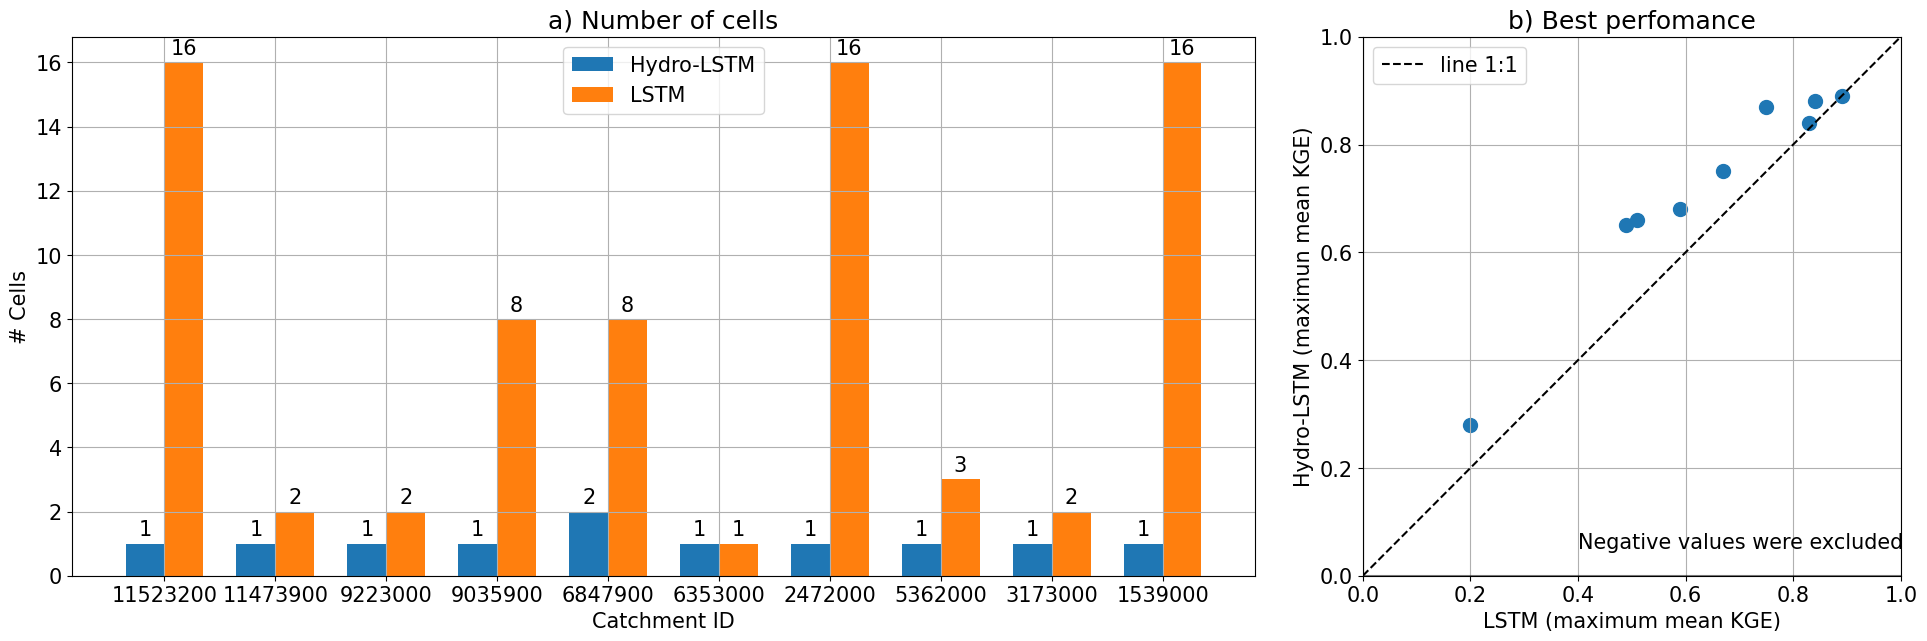

In [10]:

codes = [11523200, 11473900,9223000,9035900,6847900,6353000,2472000,5362000,3173000,1539000]

pars = pd.DataFrame(columns=['code','lag', 'cell','model', 'best_KGE'])

#Recent rainfall-dominant (West): 11523200, 11473900
#Snowmelt-dominant: 9223000, 9035900
#Mixed: 6847900, 6353000
#Historical rainfall-dominant: 2472000, 5362000
#Recent rainfall-dominant (East): 3173000, 1539000

array_LSTM = np.empty((6,8))
array_Hydro = np.empty((6,8))

print(np.unique(equif.code))
i=0
for code in codes:
    summary = equif[equif['code'] == code].copy()
    summary = summary[summary['model'] == 'Hydro-LSTM'].copy()
    summary = summary.sort_values(by=['cell', 'lag']).copy()
    summary = summary.reset_index(drop=True)

    pars.loc[i,'code'] = code 
    pars.loc[i,'model'] = summary.loc[0,'model']
    pars.loc[i,'lag'] = summary.loc[0,'lag']
    pars.loc[i,'cell'] = summary.loc[0,'cell']
    i = i + 1
    summary = equif[equif['code'] == code].copy()
    summary = summary[summary['model'] == 'LSTM'].copy()
    summary = summary.sort_values(by=['cell', 'lag']).copy()
    summary = summary.reset_index(drop=True)
    pars.loc[i,'code'] = code
    pars.loc[i,'model'] = summary.loc[0,'model']

    pars.loc[i,'lag'] = summary.loc[0,'lag']
    pars.loc[i,'cell'] = summary.loc[0,'cell']
    i = i + 1
    
Hydro = pars.cell[pars['model']=='Hydro-LSTM']
Lstm = pars.cell[pars['model']=='LSTM']

x = np.arange(len(codes))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1,3, figsize=(23.6,7))
gs = ax[0].get_gridspec()
for axs in ax[0:2]:
    axs.remove()
axbig = fig.add_subplot(gs[0:2])
axbig.grid()
rects1 = axbig.bar(x - width/2, Hydro, width, label='Hydro-LSTM')
rects2 = axbig.bar(x + width/2, Lstm, width, label='LSTM')
axbig.set_ylabel('# Cells')
axbig.set_xlabel('Catchment ID')
#ax.set_title('Cell comparison')
axbig.set_xticks(x)
axbig.set_xticklabels(codes)
axbig.legend()
axbig.bar_label(rects1, padding=3)
axbig.bar_label(rects2, padding=3)
axbig.set_title('a) Number of cells')

Hydro = pars.lag[pars['model']=='Hydro-LSTM']
Lstm = pars.lag[pars['model']=='LSTM']


i = 0
for code in codes:
    pars.loc[i,'best_KGE'] = round(mean_results_hydro.KGE[mean_results_hydro.code == code].max(),2)
    i = i + 1    
    pars.loc[i,'best_KGE'] = round(mean_results_LSTM.KGE[mean_results_LSTM.code == code].max(),2)
    i = i + 1



ax[2].scatter(pars.best_KGE[pars.model == 'LSTM'] ,pars.best_KGE[pars.model == 'Hydro-LSTM'], s=100)

ax[2].plot([0,1], [0,1],'k--', label='line 1:1')
ax[2].plot([-1,1], [0,0],'k-', alpha=0.5)
ax[2].plot([0,0], [-1,1],'k-', alpha=0.5)
ax[2].margins(0.0, tight=True)
ax[2].set_xlim(0,1)
ax[2].set_ylim(0,1)
ax[2].grid()
ax[2].set_xlabel('LSTM (maximum mean KGE)')
ax[2].set_ylabel('Hydro-LSTM (maximun mean KGE)')
ax[2].legend()
ax[2].text(0.4, 0.05,"Negative values were excluded")
ax[2].set_title('b) Best perfomance')


plt.savefig('Fig4.jpg',  bbox_inches="tight")


# Table B1. Comparison between LSTM and Hydro-LSTM (small dataset)

In [11]:
pars

code  lag cell       model best_KGE
0   11523200   64    1  Hydro-LSTM     0.75
1   11523200   64   16        LSTM     0.67
2   11473900   32    1  Hydro-LSTM     0.88
3   11473900   32    2        LSTM     0.84
4    9223000   32    1  Hydro-LSTM     0.84
5    9223000   64    2        LSTM     0.83
6    9035900  256    1  Hydro-LSTM     0.89
7    9035900   64    8        LSTM     0.89
8    6847900    4    2  Hydro-LSTM     0.28
9    6847900   16    8        LSTM      0.2
10   6353000   32    1  Hydro-LSTM    -0.75
11   6353000   16    1        LSTM    -1.62
12   2472000   16    1  Hydro-LSTM     0.87
13   2472000   64   16        LSTM     0.75
14   5362000   32    1  Hydro-LSTM     0.66
15   5362000  128    3        LSTM     0.51
16   3173000   16    1  Hydro-LSTM     0.68
17   3173000  256    2        LSTM     0.59
18   1539000    4    1  Hydro-LSTM     0.65
19   1539000   32   16        LSTM     0.49

# Figure B1. State variable evolution  

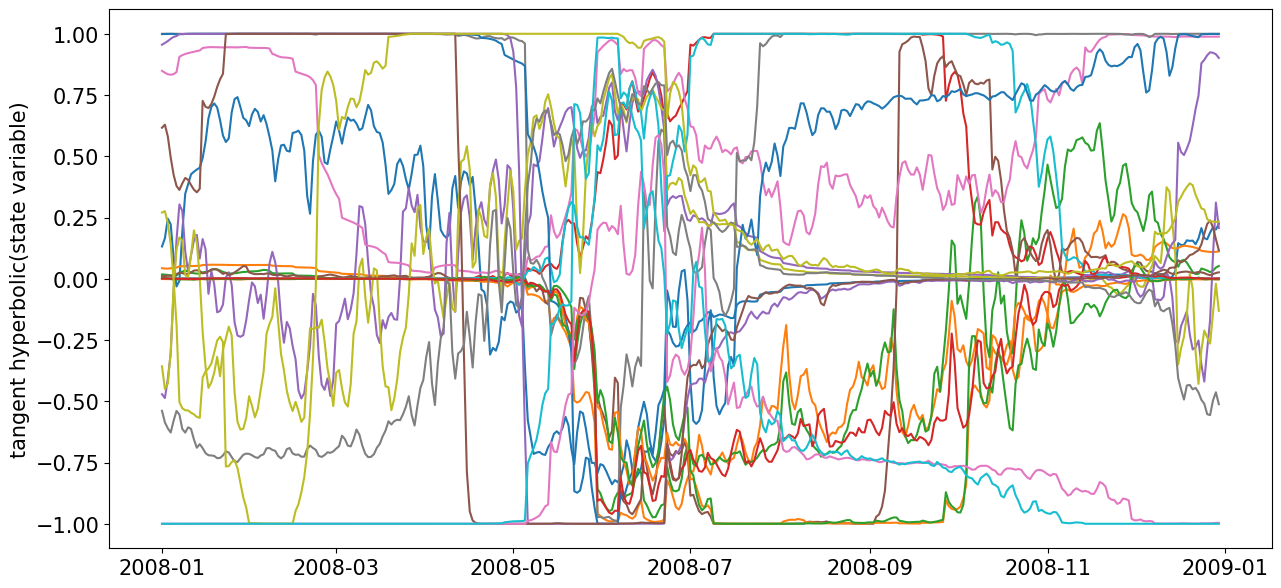

In [12]:
current_path = os.getcwd()
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Results/'

catchment_ID = 9035900
lag_ID = 256

path_state = path + 'hydro/'+ str(catchment_ID) + '_C' + str(1) + '_L' + str(lag_ID) + '_hydro_state.csv'
hydro_state = pd.read_csv(path_state)
hydro_state = hydro_state.drop(columns=['Unnamed: 0'])
plt.figure(figsize=(15,7))
plt.plot(np.arange(np.datetime64('2008-01-01'), np.datetime64('2008-12-31')),np.tanh(hydro_state.tail(365)))
plt.ylabel('tangent hyperbolic(state variable)')

plt.savefig('FigB1.jpg',  bbox_inches="tight")

# Fig5. Weights distribution

In [13]:
def plot_output_gate(ID, cell, lag, models, p_value_threshold, iter_pos, fitting_PP, fitting_ET, p0_PP, p0_ET,subplot): #function that plots all the cathments
    # gate: 0:forget 1:input 2:output 3:g(x)
    percentile_range = 50
    classif = ['Region: Recent rainfall-dominant (West)','Region: Recent rainfall-dominant (West)','Region: Snowmelt-dominant','Region: Snowmelt-dominant','Region: Mixed','Region: Mixed','Region: Historical rainfall-dominant','Region: Historical rainfall-dominant','Region: Recent rainfall-dominant (East)','Region: Recent rainfall-dominant (East)']
    ylim_max = [2.5,2,1,2,1,1.25,1.25,2,2,3]
    mean_KGE = [0.78, 0.80, 0.79, 0.89, 0.0,-1.21,0.86, 0.62, 0.64, 0.63]
    gate_name = ['Forget gate', 'Input gate', 'Output gate', 'g(x)']
    
    PP_w = np.zeros((20,(lag+1),4))
    ET_w = np.zeros((20,(lag+1),4))
    bias = np.zeros((4,20))
    recurr = np.zeros((4,20))
    linear_w = np.zeros(20)
    linear_bias = np.zeros(20)
    PP_w_test = np.zeros((4,(lag+1))) 
    ET_w_test = np.zeros((4,(lag+1)))
    PP_w_test_ci_up = np.zeros((4,(lag+1))) 
    ET_w_test_ci_up = np.zeros((4,(lag+1)))
    PP_w_test_ci_down = np.zeros((4,(lag+1))) 
    ET_w_test_ci_down = np.zeros((4,(lag+1)))
    x = np.arange(lag+1)
    x_simp = np.zeros((20,lag+1))
    
    for jj in range(20):
        x_simp[jj,:] = x
    x_simp = np.reshape(x_simp, -1)

    for gate in range(3):
        mean_model = models[0]
        for i in range(20):
            PP_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,:lag+1].detach().numpy()
            ET_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,lag+1:].detach().numpy()
            bias[gate,i] = models[i].hydro_lstm.bias[gate,0].detach().numpy()
            recurr[gate,i] = models[i].hydro_lstm.weight_recur[gate,0].detach().numpy()
            linear_w[i] = models[i].regression.weight.detach().numpy()
            linear_bias[i] = models[i].regression.bias.detach().numpy()
        for j in range(lag+1):
            _,p_value =stats.ttest_1samp(PP_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                PP_w_test[gate,j] = 0 
            else: 
                PP_w_test[gate,j] = np.median(PP_w[:,j,gate])
                PP_w_test_ci_up[gate,j] = np.percentile(PP_w[:,j,gate],50 + percentile_range/2)
                PP_w_test_ci_down[gate,j] = np.percentile(PP_w[:,j,gate],50 - percentile_range/2)
            _,p_value =stats.ttest_1samp(ET_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                ET_w_test[gate,j] = 0 
            else:
                ET_w_test[gate,j] = np.median(ET_w[:,j,gate])
                ET_w_test_ci_up[gate,j] = np.percentile(ET_w[:,j,gate],50 + percentile_range/2)
                ET_w_test_ci_down[gate,j] = np.percentile(ET_w[:,j,gate],50 - percentile_range/2)



        plt.subplot(10,3,iter_pos + gate)
        plt.fill_between(np.arange(lag+1)+0.1,PP_w_test_ci_up[gate,:],PP_w_test_ci_down[gate,:], color='blue', alpha=.1, label='Precipitation (50% percentile area)') 
        plt.fill_between(np.arange(lag+1)+0.1,ET_w_test_ci_up[gate,:],ET_w_test_ci_down[gate,:], color='red', alpha=.1, label = 'Pot. Evapotrans. (50% percentile area)') 
        plt.grid()
        title = str(ID) + ' - ' + gate_name[gate] # ' (KGE=' + str(mean_KGE[iter_pos//4]) + ')'
        plt.title(title)
        plt.ylabel('Weight for each input')
        plt.xlabel('Lag(Days)')
        plt.text(0.15,-0.9,classif[iter_pos//3])
        plt.ylim(-1,ylim_max[iter_pos//3])
        plt.xlim(0.1,lag+1)
        plt.xscale('log')
        
        PP_w[:,j,gate]
        PP_simp_rows = PP_w[:,:,gate]
        if fitting_PP==True:           
            PP_simp = np.reshape(PP_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, PP_simp, p0=p0_PP):
                arr_PP = np.zeros(lag+1)
            else:                   
                popt, _ = curve_fit(summ_, x_simp, PP_simp, p0=p0_PP)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:blue', linestyle='dashed', label='Precip. (Exp.+ Nor. fitting)')
                arr_PP = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PP = np.mean(PP_simp_rows, axis=0)

        ET_simp_rows = ET_w[:,:,gate]
        if fitting_ET==True:
            ET_simp = np.reshape(ET_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, ET_simp, p0=p0_ET):
                arr_PET = np.zeros(lag+1)
            else:
                popt, _ = curve_fit(summ_, x_simp, ET_simp, p0=p0_ET)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:red', linestyle='dashed', label='Evapot. (Exp.+ Nor. fitting)')
                arr_PET = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PET = np.mean(ET_simp_rows, axis=0)            
            
        if subplot==True:
            plt.xlim(0,32)
        plt.legend()
    

def plot_output_gate_2(ID, cell, lag, models, p_value_threshold, iter_pos, fitting_PP, fitting_ET, p0_PP, p0_ET,subplot): #Short version that shows only catchment
    # gate: 0:forget 1:input 2:output 3:g(x)
    percentile_range = 50
    classif = ['Region: Recent rainfall-dominant (West)','Region: Snowmelt-dominant']
    ylim_max = [2,2]
    mean_KGE = [0.80, 0.89]
    gate_name = ['Forget gate', 'Input gate', 'Output gate', 'g(x)']
    
    PP_w = np.zeros((20,(lag+1),4))
    ET_w = np.zeros((20,(lag+1),4))
    bias = np.zeros((4,20))
    recurr = np.zeros((4,20))
    linear_w = np.zeros(20)
    linear_bias = np.zeros(20)
    PP_w_test = np.zeros((4,(lag+1))) 
    ET_w_test = np.zeros((4,(lag+1)))
    PP_w_test_ci_up = np.zeros((4,(lag+1))) 
    ET_w_test_ci_up = np.zeros((4,(lag+1)))
    PP_w_test_ci_down = np.zeros((4,(lag+1))) 
    ET_w_test_ci_down = np.zeros((4,(lag+1)))
    x = np.arange(lag+1)
    x_simp = np.zeros((20,lag+1))
    
    for jj in range(20):
        x_simp[jj,:] = x
    x_simp = np.reshape(x_simp, -1)

    for gate in range(3):
        mean_model = models[0]
        for i in range(20):
            PP_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,:lag+1].detach().numpy()
            ET_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,lag+1:].detach().numpy()
            bias[gate,i] = models[i].hydro_lstm.bias[gate,0].detach().numpy()
            recurr[gate,i] = models[i].hydro_lstm.weight_recur[gate,0].detach().numpy()
            linear_w[i] = models[i].regression.weight.detach().numpy()
            linear_bias[i] = models[i].regression.bias.detach().numpy()
        for j in range(lag+1):
            _,p_value =stats.ttest_1samp(PP_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                PP_w_test[gate,j] = 0 
            else: 
                PP_w_test[gate,j] = np.median(PP_w[:,j,gate])
                PP_w_test_ci_up[gate,j] = np.percentile(PP_w[:,j,gate],50 + percentile_range/2)
                PP_w_test_ci_down[gate,j] = np.percentile(PP_w[:,j,gate],50 - percentile_range/2)
            _,p_value =stats.ttest_1samp(ET_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                ET_w_test[gate,j] = 0 
            else:
                ET_w_test[gate,j] = np.median(ET_w[:,j,gate])
                ET_w_test_ci_up[gate,j] = np.percentile(ET_w[:,j,gate],50 + percentile_range/2)
                ET_w_test_ci_down[gate,j] = np.percentile(ET_w[:,j,gate],50 - percentile_range/2)



        plt.subplot(2,3,iter_pos + gate)
        plt.fill_between(np.arange(lag+1)+0.1,PP_w_test_ci_up[gate,:],PP_w_test_ci_down[gate,:], color='blue', alpha=.1, label='Precipitation (50% percentile)') 
        plt.fill_between(np.arange(lag+1)+0.1,ET_w_test_ci_up[gate,:],ET_w_test_ci_down[gate,:], color='red', alpha=.1, label = 'Pot. Evapotrans. (50% percentile)') 
        plt.grid()
        title = str(ID) + ' - ' + gate_name[gate] # ' (KGE=' + str(mean_KGE[iter_pos//4]) + ')'
        plt.title(title, fontsize=20)
        plt.ylabel('Weight for each input',fontsize=15)
        plt.xlabel('Lag(Days)',fontsize=15)
        plt.ylim(-1,ylim_max[iter_pos//3])
        plt.xlim(0.1,lag+1)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xscale('log')
        
        PP_w[:,j,gate]
        PP_simp_rows = PP_w[:,:,gate]
        if fitting_PP==True:           
            PP_simp = np.reshape(PP_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, PP_simp, p0=p0_PP):
                arr_PP = np.zeros(lag+1)
            else:                   
                popt, _ = curve_fit(summ_, x_simp, PP_simp, p0=p0_PP)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:blue', linestyle='dashed', label='Precip. (Exp.+ Nor. fitting)')
                arr_PP = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PP = np.mean(PP_simp_rows, axis=0)
            plt.plot(np.arange(lag+1)+0.1, arr_PP, alpha=0.8, color='tab:blue', linestyle='dashed', label='Mean precip. weights')

        ET_simp_rows = ET_w[:,:,gate]
        if fitting_ET==True:
            ET_simp = np.reshape(ET_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, ET_simp, p0=p0_ET):
                arr_PET = np.zeros(lag+1)
            else:
                popt, _ = curve_fit(summ_, x_simp, ET_simp, p0=p0_ET)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:red', linestyle='dashed', label='Evapot. (Exp.+ Nor. fitting)')
                arr_PET = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PET = np.mean(ET_simp_rows, axis=0)            
            plt.plot(np.arange(lag+1)+0.1, arr_PET, alpha=0.8, color='tab:red', linestyle='dashed', label='Mean pot. evapot. weights')

            
        if subplot==True:
            plt.xlim(0,32)
        if iter_pos + gate == 3:
            plt.legend()
        if iter_pos + gate == 6:
            plt.legend()        
    
def plot_output_gate3(ID, cell, lag, models, p_value_threshold, iter_pos, fitting_PP, fitting_ET, p0_PP, p0_ET,subplot): #short version that plots first 5 the cathments
    # gate: 0:forget 1:input 2:output 3:g(x)
    percentile_range = 50
    classif = ['Region: Recent rainfall-dominant (West)','Region: Recent rainfall-dominant (West)','Region: Snowmelt-dominant','Region: Snowmelt-dominant','Region: Mixed']
    ylim_max = [2.5,2,1,2,1]
    mean_KGE = [0.78, 0.80, 0.79, 0.89, 0.0]
    gate_name = ['Forget gate', 'Input gate', 'Output gate', 'g(x)']
    
    PP_w = np.zeros((20,(lag+1),4))
    ET_w = np.zeros((20,(lag+1),4))
    bias = np.zeros((4,20))
    recurr = np.zeros((4,20))
    linear_w = np.zeros(20)
    linear_bias = np.zeros(20)
    PP_w_test = np.zeros((4,(lag+1))) 
    ET_w_test = np.zeros((4,(lag+1)))
    PP_w_test_ci_up = np.zeros((4,(lag+1))) 
    ET_w_test_ci_up = np.zeros((4,(lag+1)))
    PP_w_test_ci_down = np.zeros((4,(lag+1))) 
    ET_w_test_ci_down = np.zeros((4,(lag+1)))
    x = np.arange(lag+1)
    x_simp = np.zeros((20,lag+1))
    
    for jj in range(20):
        x_simp[jj,:] = x
    x_simp = np.reshape(x_simp, -1)

    for gate in range(3):
        mean_model = models[0]
        for i in range(20):
            PP_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,:lag+1].detach().numpy()
            ET_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,lag+1:].detach().numpy()
            bias[gate,i] = models[i].hydro_lstm.bias[gate,0].detach().numpy()
            recurr[gate,i] = models[i].hydro_lstm.weight_recur[gate,0].detach().numpy()
            linear_w[i] = models[i].regression.weight.detach().numpy()
            linear_bias[i] = models[i].regression.bias.detach().numpy()
        for j in range(lag+1):
            _,p_value =stats.ttest_1samp(PP_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                PP_w_test[gate,j] = 0 
            else: 
                PP_w_test[gate,j] = np.median(PP_w[:,j,gate])
                PP_w_test_ci_up[gate,j] = np.percentile(PP_w[:,j,gate],50 + percentile_range/2)
                PP_w_test_ci_down[gate,j] = np.percentile(PP_w[:,j,gate],50 - percentile_range/2)
            _,p_value =stats.ttest_1samp(ET_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                ET_w_test[gate,j] = 0 
            else:
                ET_w_test[gate,j] = np.median(ET_w[:,j,gate])
                ET_w_test_ci_up[gate,j] = np.percentile(ET_w[:,j,gate],50 + percentile_range/2)
                ET_w_test_ci_down[gate,j] = np.percentile(ET_w[:,j,gate],50 - percentile_range/2)



        plt.subplot(5,3,iter_pos + gate)
        plt.fill_between(np.arange(lag+1)+0.1,PP_w_test_ci_up[gate,:],PP_w_test_ci_down[gate,:], color='blue', alpha=.1, label='Precipitation (50% percentile area)') 
        plt.fill_between(np.arange(lag+1)+0.1,ET_w_test_ci_up[gate,:],ET_w_test_ci_down[gate,:], color='red', alpha=.1, label = 'Pot. Evapotrans. (50% percentile area)') 
        plt.grid()
        title = str(ID) + ' - ' + gate_name[gate] # ' (KGE=' + str(mean_KGE[iter_pos//4]) + ')'
        plt.title(title)
        plt.ylabel('Weight for each input',fontsize=15)
        plt.xlabel('Lag(Days)',fontsize=15)
        plt.text(0.15,-0.9,classif[iter_pos//3])
        plt.ylim(-1,ylim_max[iter_pos//3])
        plt.xlim(0.1,lag+1)
        plt.xscale('log')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
        PP_w[:,j,gate]
        PP_simp_rows = PP_w[:,:,gate]
        if fitting_PP==True:           
            PP_simp = np.reshape(PP_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, PP_simp, p0=p0_PP):
                arr_PP = np.zeros(lag+1)
            else:                   
                popt, _ = curve_fit(summ_, x_simp, PP_simp, p0=p0_PP)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:blue', linestyle='dashed', label='Precip. (Exp.+ Nor. fitting)')
                arr_PP = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PP = np.mean(PP_simp_rows, axis=0)
            plt.plot(np.arange(lag+1)+0.1, arr_PP, alpha=0.8, color='tab:blue', linestyle='dashed', label='Mean precip. weights')

        ET_simp_rows = ET_w[:,:,gate]
        if fitting_ET==True:
            ET_simp = np.reshape(ET_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, ET_simp, p0=p0_ET):
                arr_PET = np.zeros(lag+1)
            else:
                popt, _ = curve_fit(summ_, x_simp, ET_simp, p0=p0_ET)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:red', linestyle='dashed', label='Evapot. (Exp.+ Nor. fitting)')
                arr_PET = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PET = np.mean(ET_simp_rows, axis=0)            
            plt.plot(np.arange(lag+1)+0.1, arr_PET, alpha=0.8, color='tab:red', linestyle='dashed', label='Mean pot. evapot. weights')

            
        if subplot==True:
            plt.xlim(0,32)
        if iter_pos + gate == 3*int((iter_pos + gate)/3):
            plt.legend(loc=1) 
            
            
def plot_output_gate4(ID, cell, lag, models, p_value_threshold, iter_pos, fitting_PP, fitting_ET, p0_PP, p0_ET,subplot): #short version that plots last 5 the cathments
    # gate: 0:forget 1:input 2:output 3:g(x)
    percentile_range = 50
    classif = ['Region: Mixed','Region: Historical rainfall-dominant','Region: Historical rainfall-dominant','Region: Recent rainfall-dominant (East)','Region: Recent rainfall-dominant (East)']
    ylim_max = [1.25,1.25,2,2,3]
    mean_KGE = [-1.21,0.86, 0.62, 0.64, 0.63]
    gate_name = ['Forget gate', 'Input gate', 'Output gate', 'g(x)']
    
    PP_w = np.zeros((20,(lag+1),4))
    ET_w = np.zeros((20,(lag+1),4))
    bias = np.zeros((4,20))
    recurr = np.zeros((4,20))
    linear_w = np.zeros(20)
    linear_bias = np.zeros(20)
    PP_w_test = np.zeros((4,(lag+1))) 
    ET_w_test = np.zeros((4,(lag+1)))
    PP_w_test_ci_up = np.zeros((4,(lag+1))) 
    ET_w_test_ci_up = np.zeros((4,(lag+1)))
    PP_w_test_ci_down = np.zeros((4,(lag+1))) 
    ET_w_test_ci_down = np.zeros((4,(lag+1)))
    x = np.arange(lag+1)
    x_simp = np.zeros((20,lag+1))
    
    for jj in range(20):
        x_simp[jj,:] = x
    x_simp = np.reshape(x_simp, -1)

    for gate in range(3):
        mean_model = models[0]
        for i in range(20):
            PP_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,:lag+1].detach().numpy()
            ET_w[i,:,gate] = models[i].hydro_lstm.weight_input[gate,lag+1:].detach().numpy()
            bias[gate,i] = models[i].hydro_lstm.bias[gate,0].detach().numpy()
            recurr[gate,i] = models[i].hydro_lstm.weight_recur[gate,0].detach().numpy()
            linear_w[i] = models[i].regression.weight.detach().numpy()
            linear_bias[i] = models[i].regression.bias.detach().numpy()
        for j in range(lag+1):
            _,p_value =stats.ttest_1samp(PP_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                PP_w_test[gate,j] = 0 
            else: 
                PP_w_test[gate,j] = np.median(PP_w[:,j,gate])
                PP_w_test_ci_up[gate,j] = np.percentile(PP_w[:,j,gate],50 + percentile_range/2)
                PP_w_test_ci_down[gate,j] = np.percentile(PP_w[:,j,gate],50 - percentile_range/2)
            _,p_value =stats.ttest_1samp(ET_w[:,j,gate],0) 
            if p_value < p_value_threshold:
                ET_w_test[gate,j] = 0 
            else:
                ET_w_test[gate,j] = np.median(ET_w[:,j,gate])
                ET_w_test_ci_up[gate,j] = np.percentile(ET_w[:,j,gate],50 + percentile_range/2)
                ET_w_test_ci_down[gate,j] = np.percentile(ET_w[:,j,gate],50 - percentile_range/2)



        plt.subplot(5,3,iter_pos + gate)
        plt.fill_between(np.arange(lag+1)+0.1,PP_w_test_ci_up[gate,:],PP_w_test_ci_down[gate,:], color='blue', alpha=.1, label='Precipitation (50% percentile area)') 
        plt.fill_between(np.arange(lag+1)+0.1,ET_w_test_ci_up[gate,:],ET_w_test_ci_down[gate,:], color='red', alpha=.1, label = 'Pot. Evapotrans. (50% percentile area)') 
        plt.grid()
        title = str(ID) + ' - ' + gate_name[gate] # ' (KGE=' + str(mean_KGE[iter_pos//4]) + ')'
        plt.title(title)
        plt.ylabel('Weight for each input',fontsize=15)
        plt.xlabel('Lag(Days)',fontsize=15)
        plt.text(0.15,-0.9,classif[iter_pos//3])
        plt.ylim(-1,ylim_max[iter_pos//3])
        plt.xlim(0.1,lag+1)
        plt.xscale('log')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
        PP_w[:,j,gate]
        PP_simp_rows = PP_w[:,:,gate]
        if fitting_PP==True:           
            PP_simp = np.reshape(PP_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, PP_simp, p0=p0_PP):
                arr_PP = np.zeros(lag+1)
            else:                   
                popt, _ = curve_fit(summ_, x_simp, PP_simp, p0=p0_PP)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:blue', linestyle='dashed', label='Precip. (Exp.+ Nor. fitting)')
                arr_PP = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PP = np.mean(PP_simp_rows, axis=0)
            plt.plot(np.arange(lag+1)+0.1, arr_PP, alpha=0.8, color='tab:blue', linestyle='dashed', label='Mean precip. weights')

        ET_simp_rows = ET_w[:,:,gate]
        if fitting_ET==True:
            ET_simp = np.reshape(ET_simp_rows, -1)
            if iserror(curve_fit,summ_, x_simp, ET_simp, p0=p0_ET):
                arr_PET = np.zeros(lag+1)
            else:
                popt, _ = curve_fit(summ_, x_simp, ET_simp, p0=p0_ET)
                plt.plot(np.arange(0,lag+1,0.1), summ_(np.arange(0,lag+1,0.1),*popt), alpha=0.8, color='tab:red', linestyle='dashed', label='Evapot. (Exp.+ Nor. fitting)')
                arr_PET = summ_(np.arange(0,lag+1,1),*popt)
        else:
            arr_PET = np.mean(ET_simp_rows, axis=0)            
            plt.plot(np.arange(lag+1)+0.1, arr_PET, alpha=0.8, color='tab:red', linestyle='dashed', label='Mean pot. evapot. weights')

            
        if subplot==True:
            plt.xlim(0,32)
        if iter_pos + gate == 3*int((iter_pos + gate)/3):
            plt.legend(loc=1)

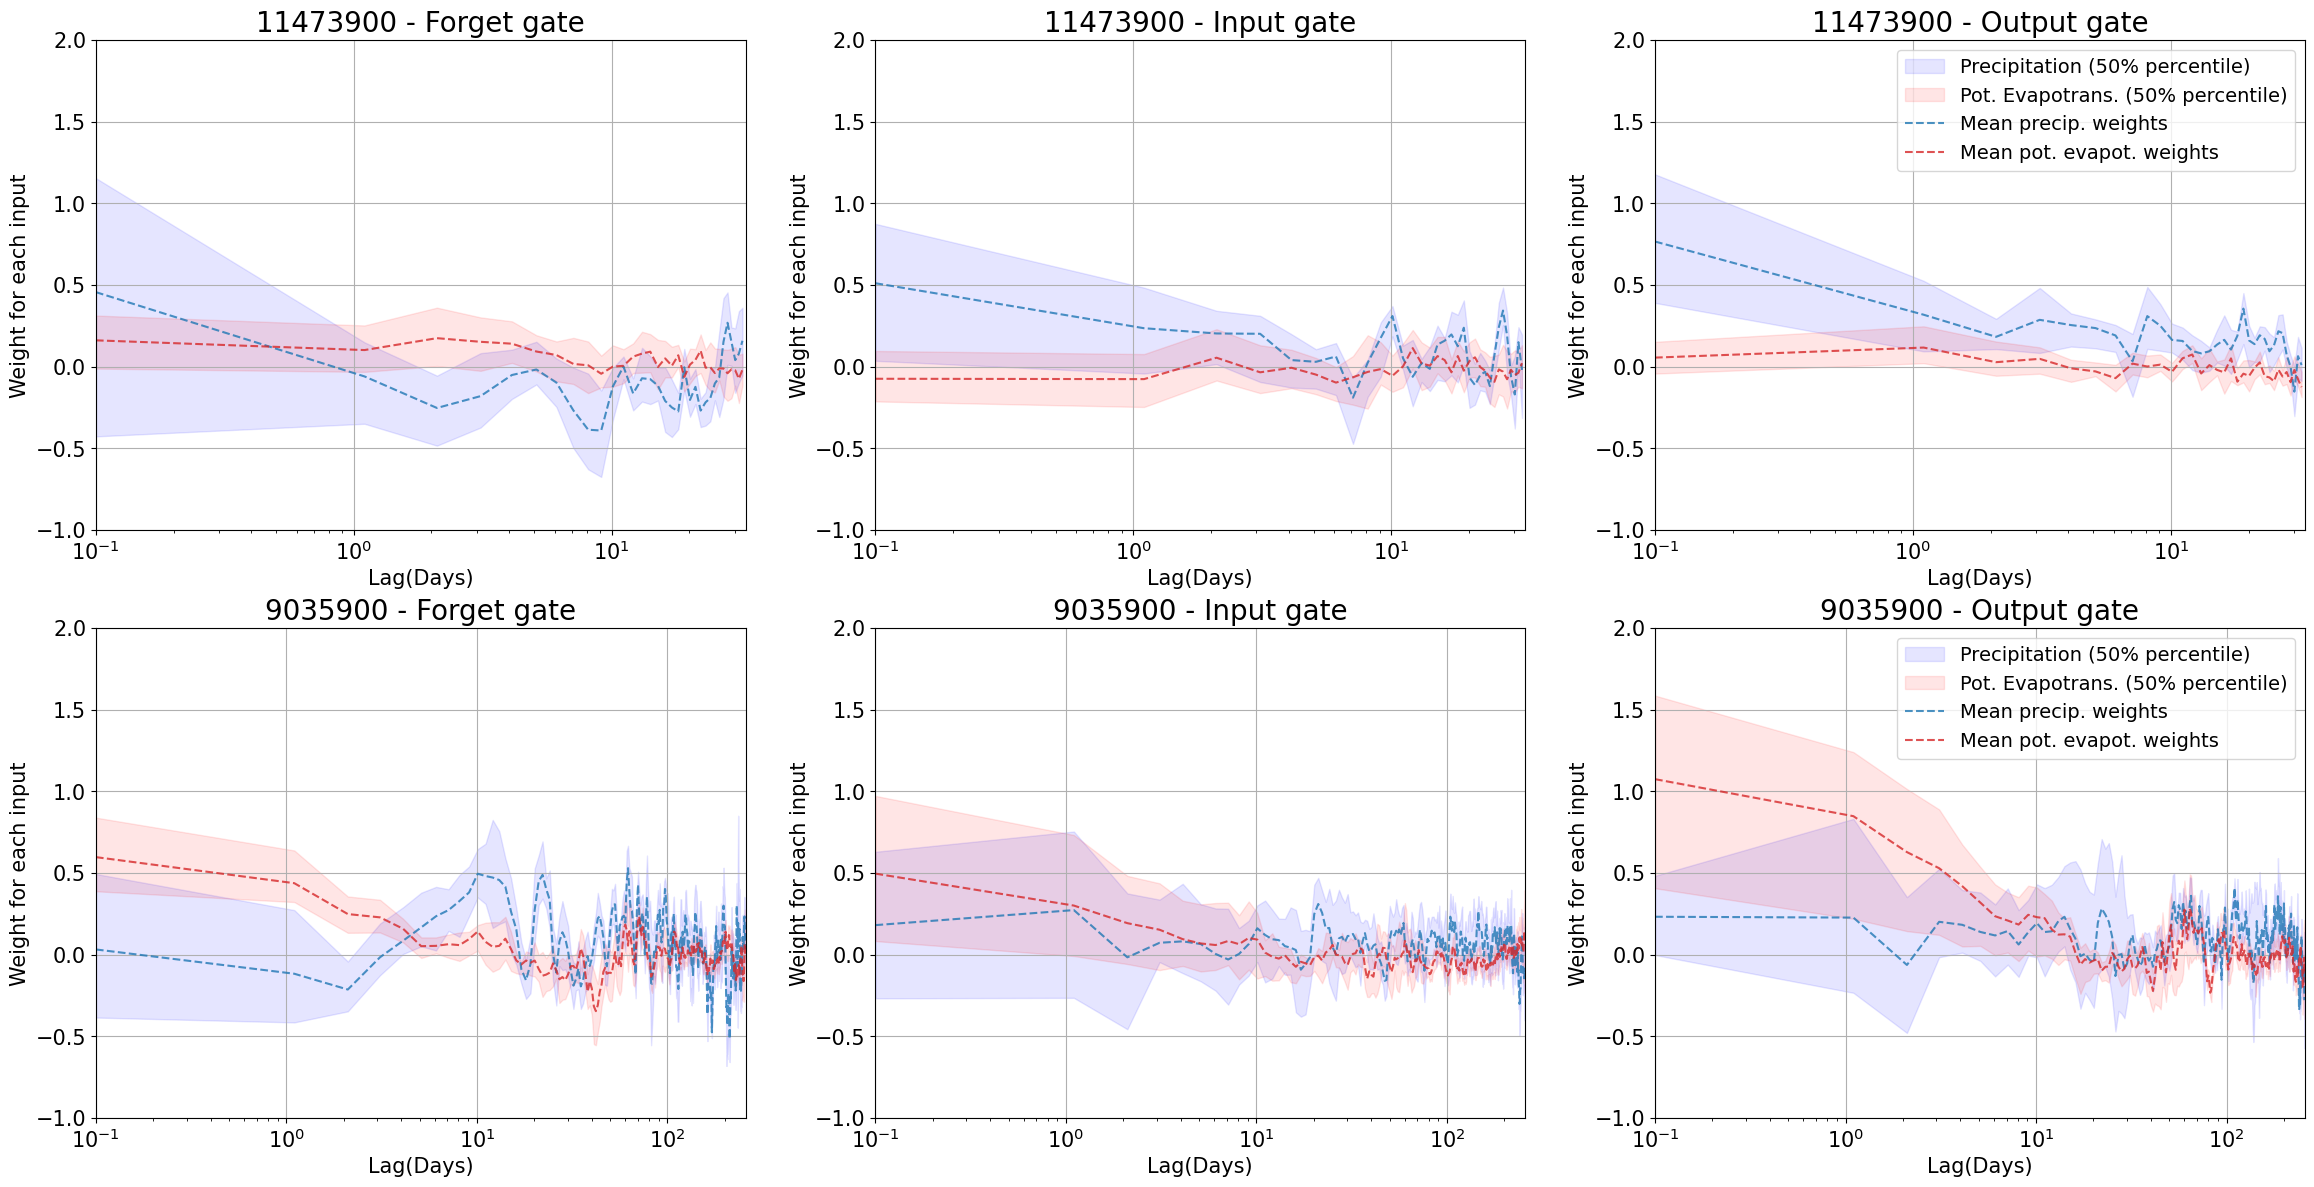

In [14]:
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Results/'

p_value_threshold = 0.0
#gate = 3 # gate: 0:forget 1:input 2:output 3:g(x)
plt.figure(figsize=(28.5,14))
plt.rcParams['font.size'] = '14'

code = 11473900
cell = 1
lag = 32
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
error = np.power(summary.RMSE,2)
plot_output_gate_2(code, cell, lag, models, p_value_threshold, 1, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 9035900
cell = 1
lag = 256
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
error = np.power(summary.RMSE,2)
plot_output_gate_2(code, cell, lag, models, p_value_threshold, 4, False,False,[0,0,0,0,0], [0,0,0,0,0], False)


plt.savefig('Fig5.jpg',bbox_inches="tight")


# Fig C1. Weights distribution

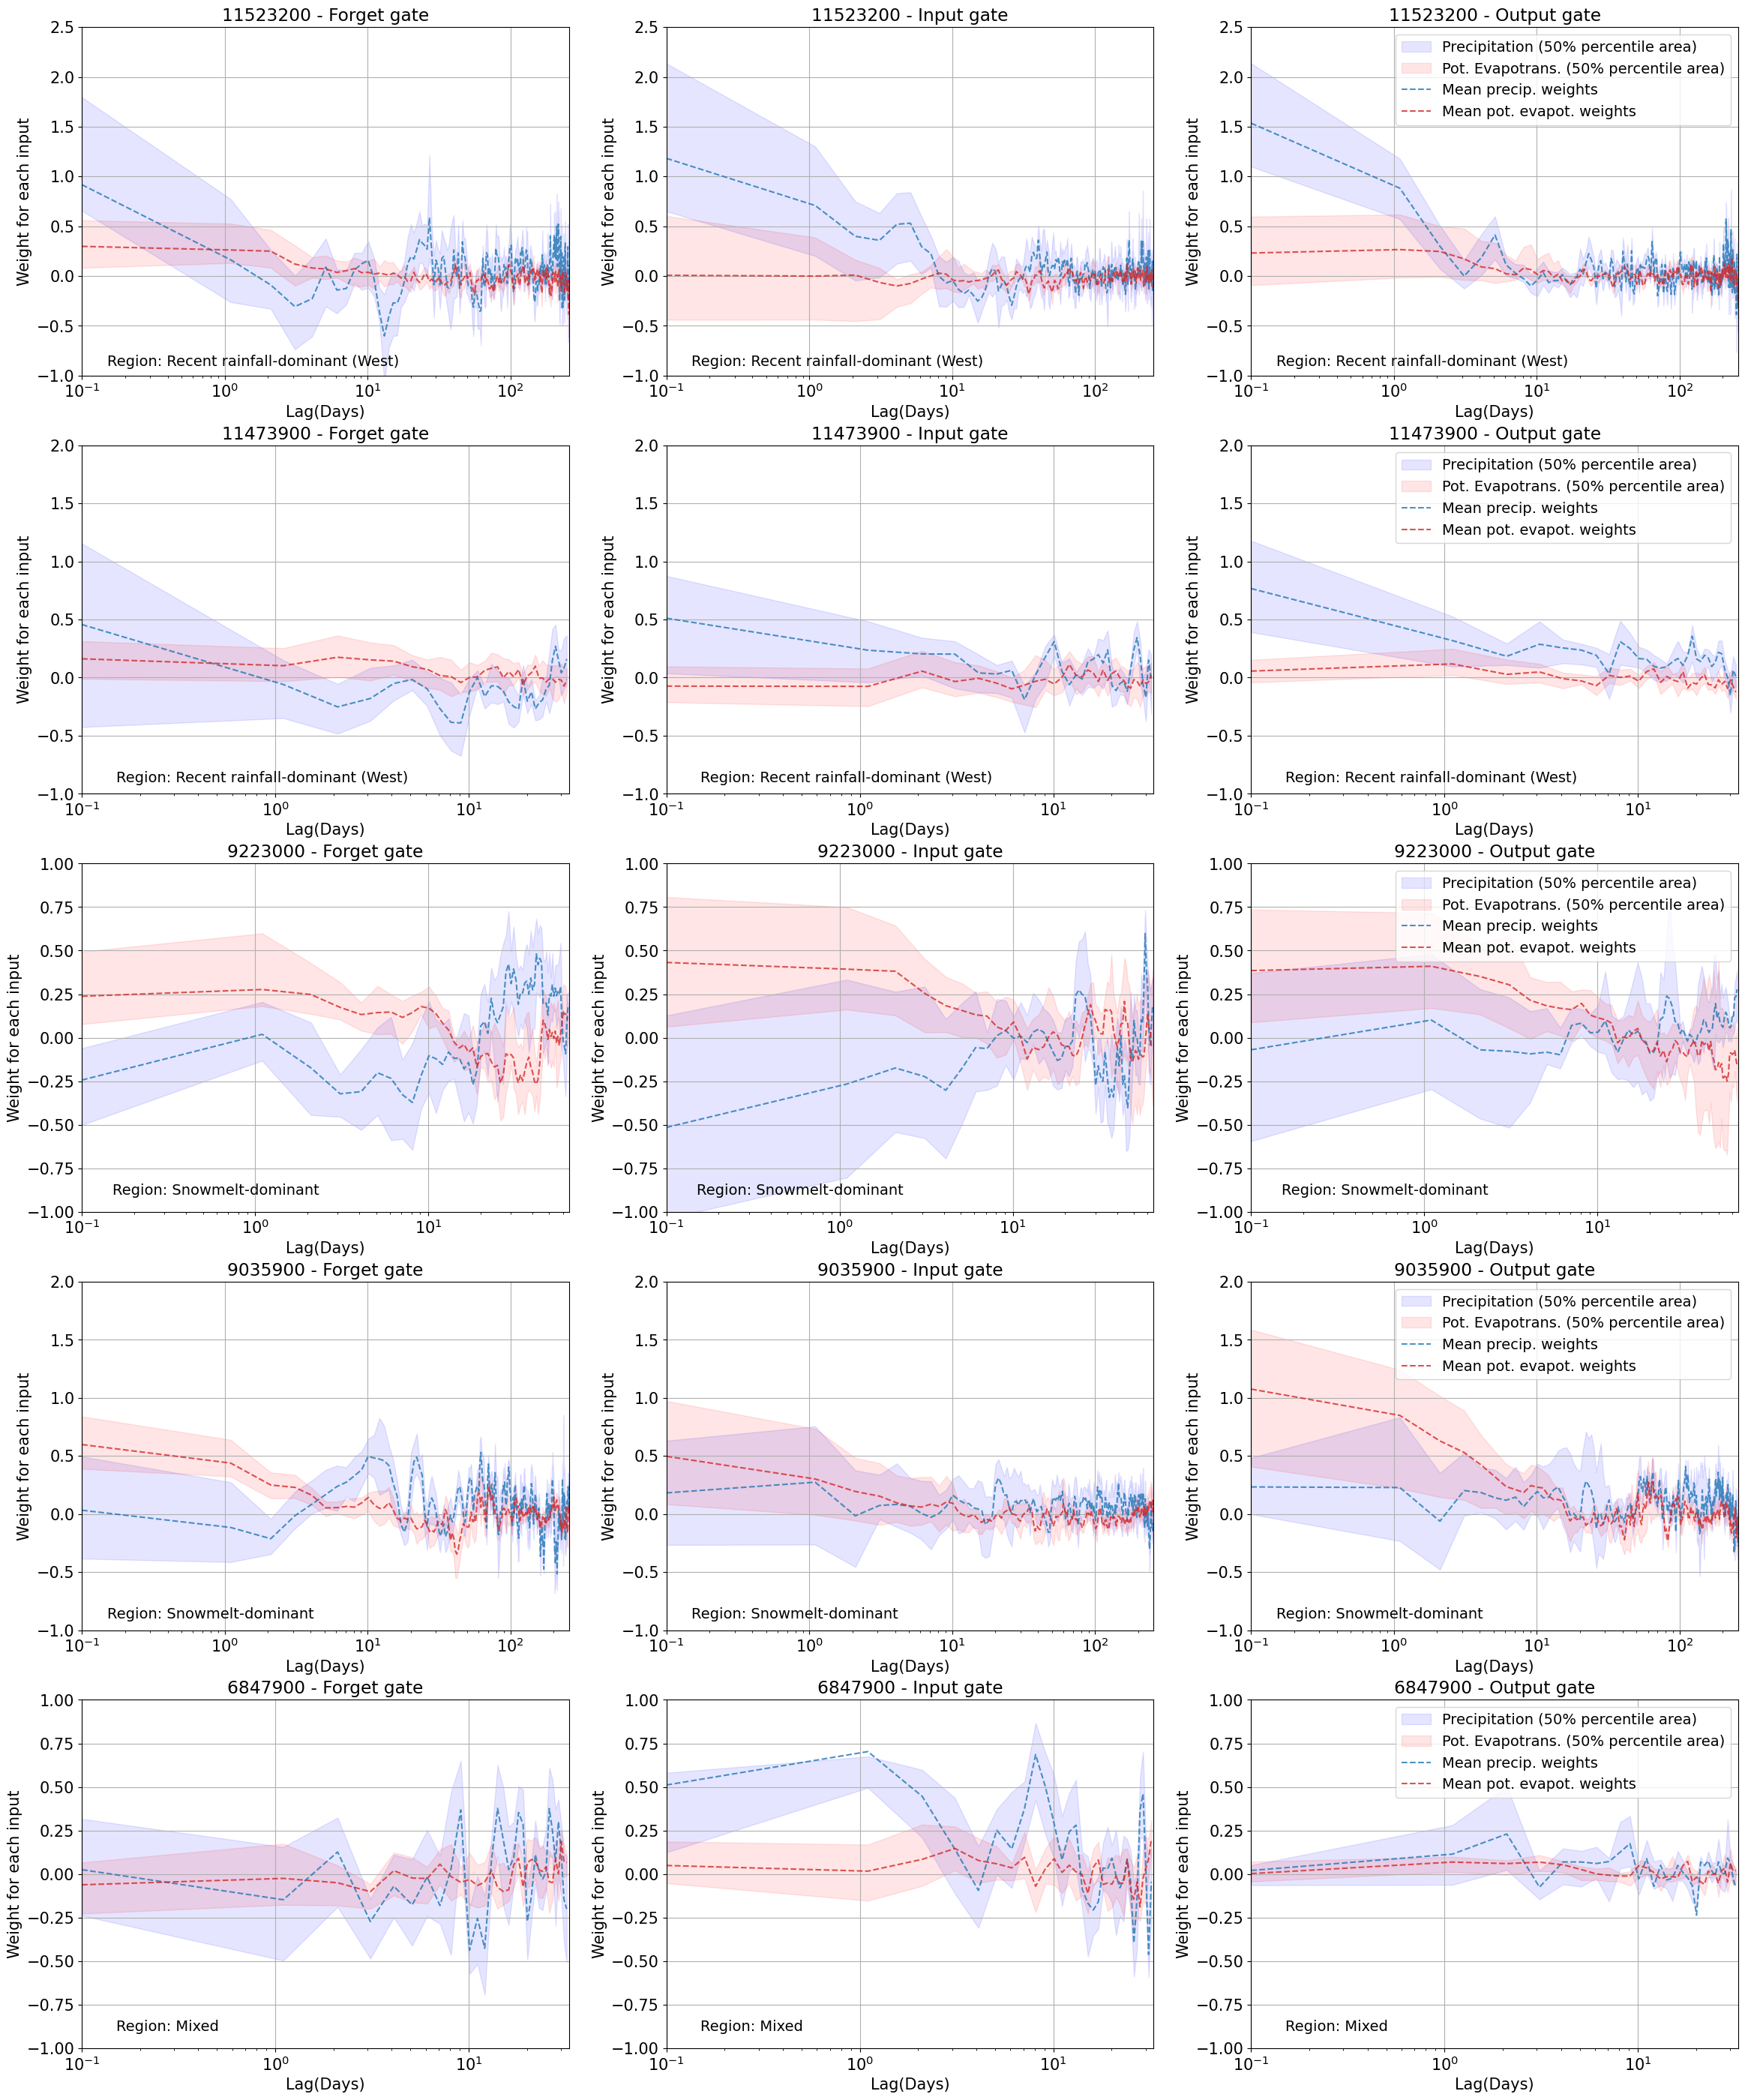

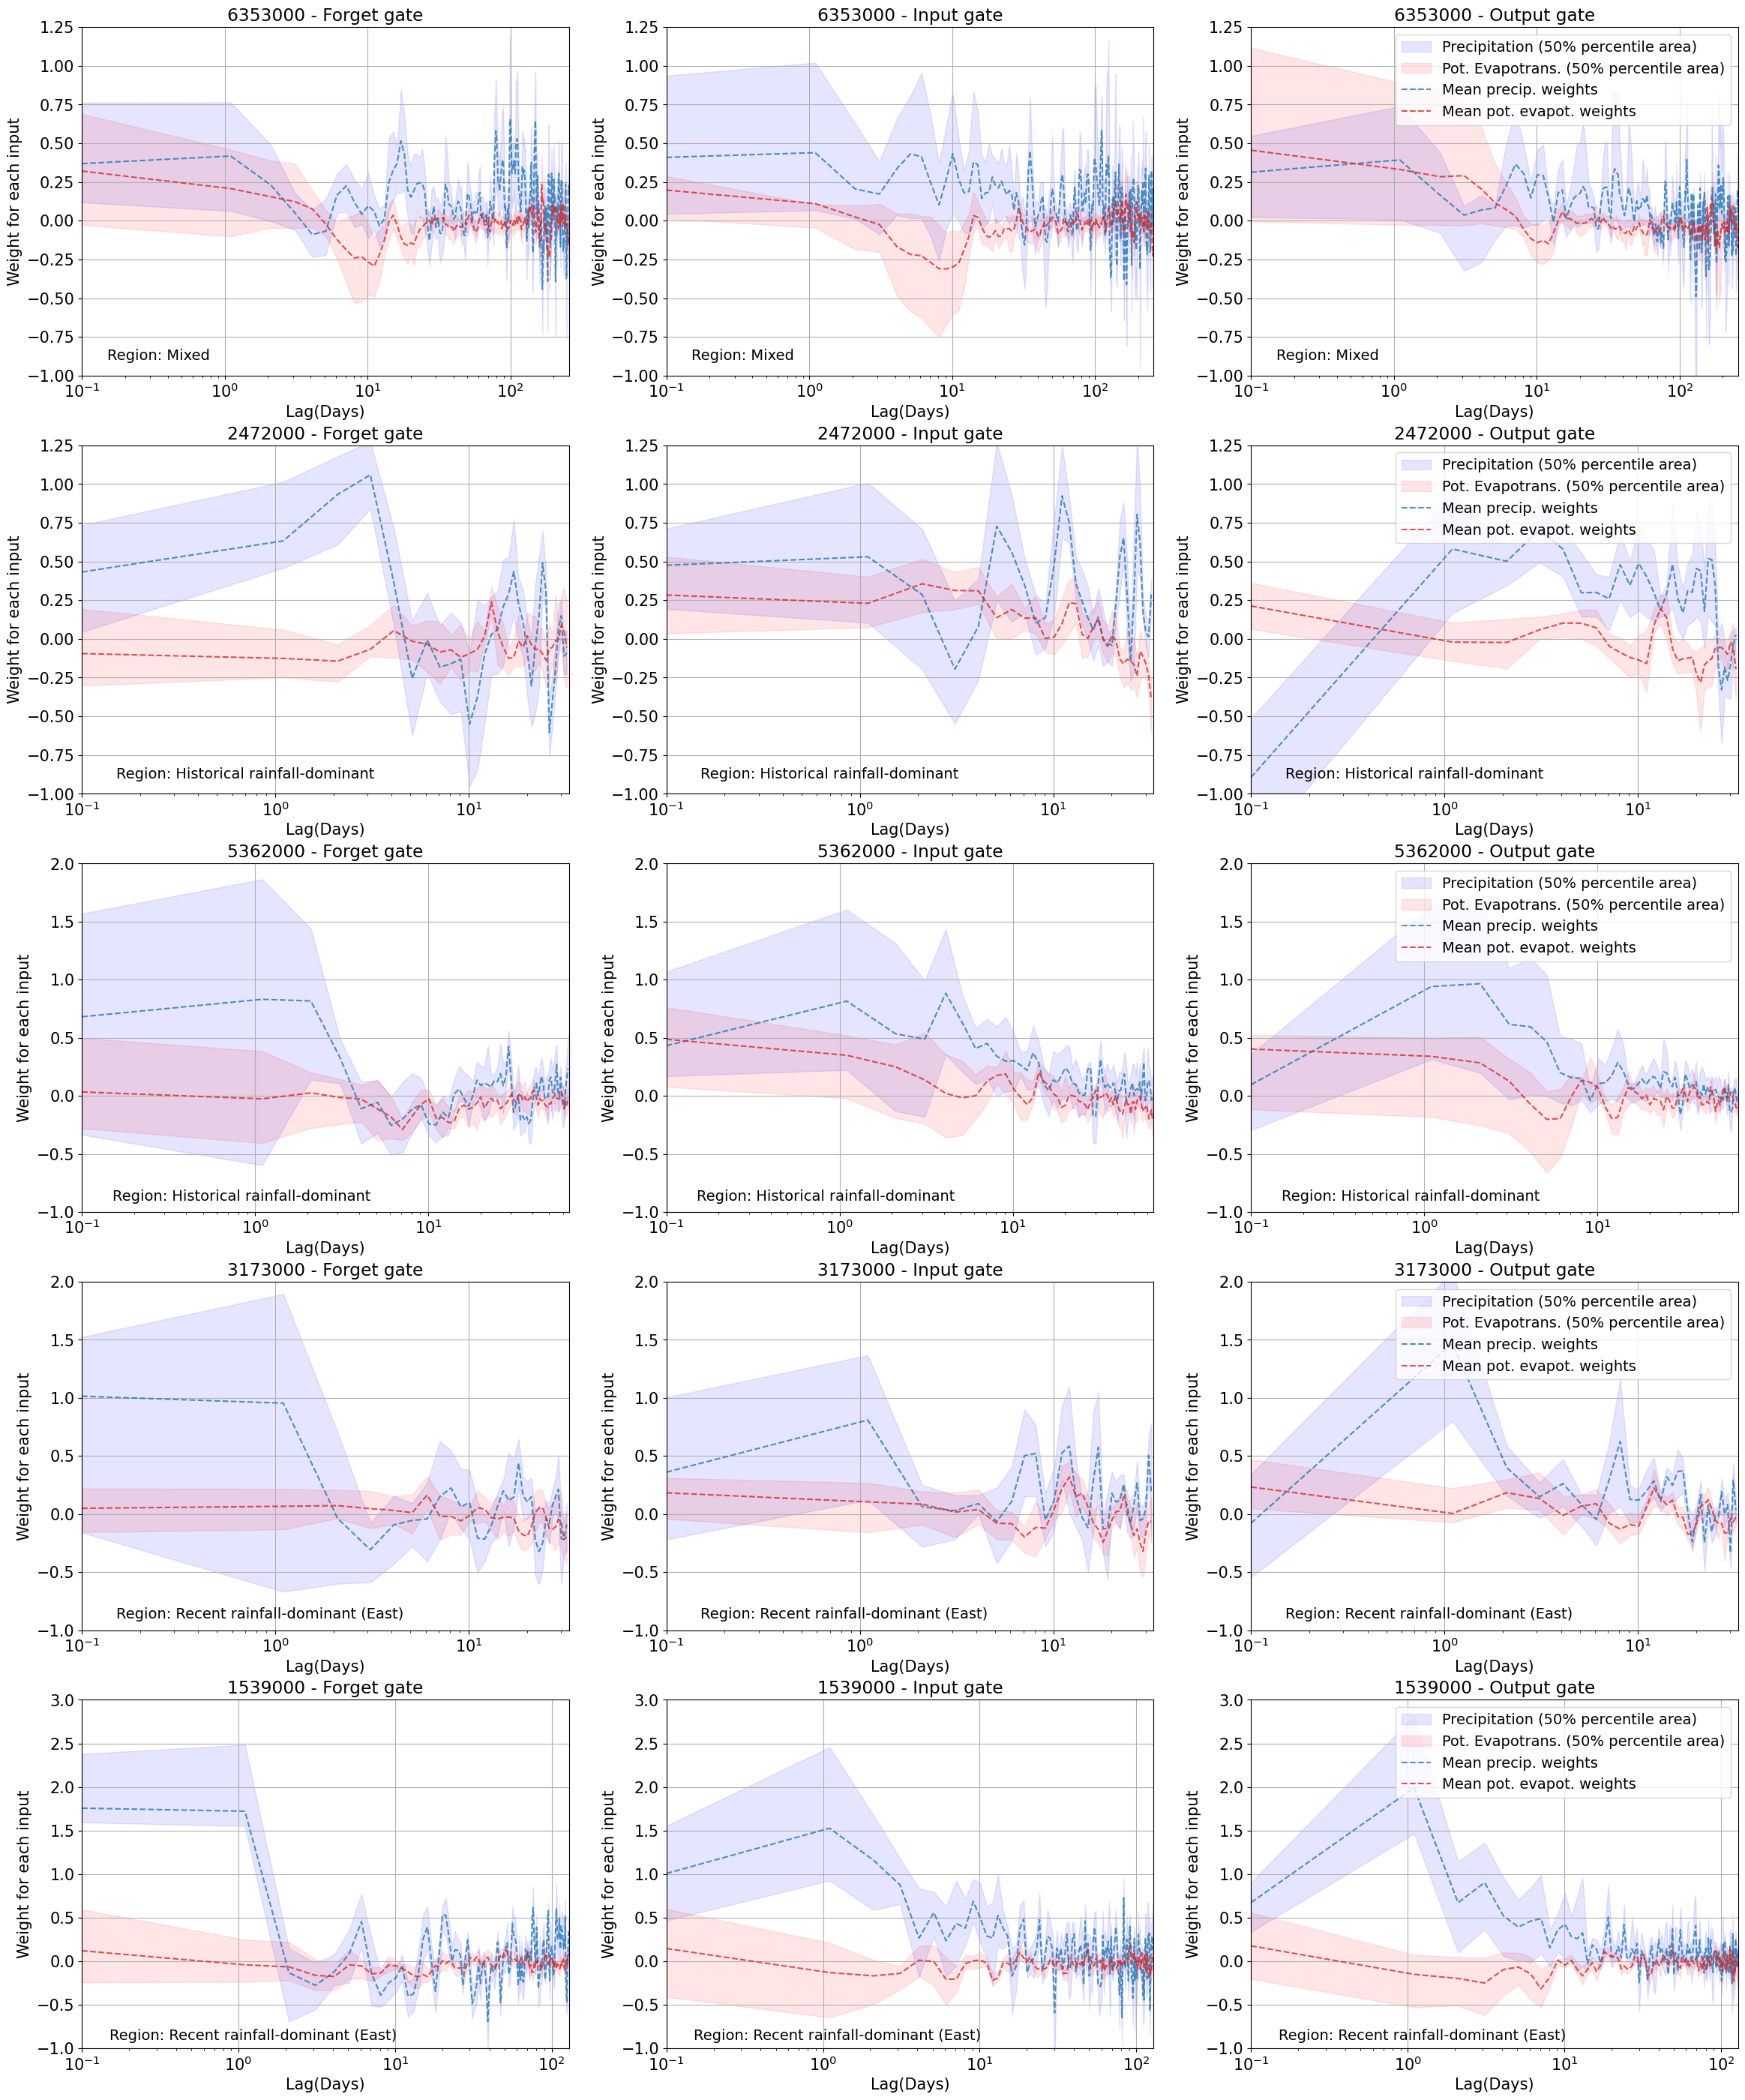

In [15]:
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Results/'

p_value_threshold = 0.0
#gate = 3 # gate: 0:forget 1:input 2:output 3:g(x)
plt.figure(figsize=(28.5,35))

code = 11523200
cell = 1
lag = 256
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate3(code, cell, lag, models, p_value_threshold, 1, False,False, [0,0,0,0,0], [0,0,0,0,0], False)

code = 11473900
cell = 1
lag = 32
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate3(code, cell, lag, models, p_value_threshold, 4, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 9223000
cell = 1
lag = 64
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate3(code, cell, lag, models, p_value_threshold, 7,False,False, [0,0,0,0,0], [0,0,0,0,0], False)

code = 9035900
cell = 1
lag = 256
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate3(code, cell, lag, models, p_value_threshold, 10, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 6847900
cell = 1
lag = 32
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate3(code, cell, lag, models, p_value_threshold, 13, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

plt.savefig('FigC1_a.jpg',bbox_inches="tight")


plt.figure(figsize=(28.5,35))

code = 6353000
cell = 1
lag = 256
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate4(code, cell, lag, models, p_value_threshold, 1, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 2472000
cell = 1
lag = 32
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate4(code, cell, lag, models, p_value_threshold, 4, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 5362000
cell = 1
lag = 64
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
error = np.power(summary.RMSE,2)
plot_output_gate4(code, cell, lag, models, p_value_threshold, 7, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 3173000
cell = 1
lag = 32
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate4(code, cell, lag, models, p_value_threshold, 10, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

code = 1539000
cell = 1
lag = 128
file_model = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_models.pkl'
models = pickle.load(open(file_model, "rb" ))
file_summary = path  + '/hydro/' + str(code) + '_C' + str(cell) + '_L' + str(lag) + '_hydro_summary.csv'
summary = pd.read_csv(file_summary)
plot_output_gate4(code, cell, lag, models, p_value_threshold, 13, False,False,[0,0,0,0,0], [0,0,0,0,0], False)

plt.savefig('FigC1_b.jpg',bbox_inches="tight")




# Fig 6 Overall perfomance in the catchment by catchment training

In [17]:
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Notebooks/'
list_path = path + '/'+ '588camels.csv'
df_list = pd.read_csv(list_path).T
df_list['KGE_4'] = np.nan
df_list['KGE_8'] = np.nan
df_list['KGE_16'] = np.nan
df_list['KGE_32'] = np.nan
df_list['KGE_64'] = np.nan
df_list['KGE_128'] = np.nan
df_list['KGE_256'] = np.nan
df_list['KGE_best'] = np.nan
df_list['lag'] = np.nan

path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Results/'
list_codes = df_list.index
print('Reading performance for each Lag and estimating the best one:')
for code in tqdm(list_codes):
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L4_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_4[code] = table.KGE.max()
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L8_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_8[code] = table.KGE.max()
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L16_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_16[code] = table.KGE.max()
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L32_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_32[code] = table.KGE.max()
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L64_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_64[code] = table.KGE.max()
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L128_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_128[code] = table.KGE.max()
    path_summary = path + '/hydro_CONUS/' + code + '_C1_L256_hydro_summary.csv'
    table = pd.read_csv(path_summary)
    df_list.KGE_256[code] = table.KGE.max()    

    if df_list.KGE_4[code] > df_list.KGE_8[code] and df_list.KGE_4[code] > df_list.KGE_32[code] and df_list.KGE_4[code] > df_list.KGE_64[code] and df_list.KGE_4[code] > df_list.KGE_128[code] and df_list.KGE_4[code] > df_list.KGE_256[code] and df_list.KGE_4[code] > df_list.KGE_16[code]:# and df_list.KGE_4[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_4[code]
        df_list.lag[code] = 4 
    if df_list.KGE_8[code] > df_list.KGE_32[code] and df_list.KGE_8[code] > df_list.KGE_64[code] and df_list.KGE_8[code] > df_list.KGE_128[code] and df_list.KGE_8[code] > df_list.KGE_256[code] and df_list.KGE_8[code] > df_list.KGE_16[code] and df_list.KGE_8[code] > df_list.KGE_4[code]:# and df_list.KGE_8[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_8[code]
        df_list.lag[code] = 8   
    if df_list.KGE_16[code] > df_list.KGE_32[code] and df_list.KGE_16[code] > df_list.KGE_64[code] and df_list.KGE_16[code] > df_list.KGE_128[code] and df_list.KGE_16[code] > df_list.KGE_256[code] and df_list.KGE_16[code] > df_list.KGE_8[code] and df_list.KGE_16[code] > df_list.KGE_4[code]:# and df_list.KGE_16[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_16[code]
        df_list.lag[code] = 16    
    if df_list.KGE_32[code] > df_list.KGE_64[code] and df_list.KGE_32[code] > df_list.KGE_128[code] and df_list.KGE_32[code] > df_list.KGE_256[code] and df_list.KGE_32[code] > df_list.KGE_16[code] and df_list.KGE_32[code] > df_list.KGE_8[code] and df_list.KGE_32[code] > df_list.KGE_4[code]:# and df_list.KGE_32[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_32[code]
        df_list.lag[code] = 32
    if df_list.KGE_64[code] > df_list.KGE_32[code] and df_list.KGE_64[code] > df_list.KGE_128[code] and df_list.KGE_64[code] > df_list.KGE_256[code] and df_list.KGE_64[code] > df_list.KGE_16[code] and df_list.KGE_64[code] > df_list.KGE_8[code] and df_list.KGE_64[code] > df_list.KGE_4[code]:# and df_list.KGE_64[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_64[code]
        df_list.lag[code] = 64
    if df_list.KGE_128[code] > df_list.KGE_32[code] and df_list.KGE_128[code] > df_list.KGE_64[code] and df_list.KGE_128[code] > df_list.KGE_256[code] and df_list.KGE_128[code] > df_list.KGE_16[code] and df_list.KGE_128[code] > df_list.KGE_8[code] and df_list.KGE_128[code] > df_list.KGE_4[code]:# and df_list.KGE_128[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_128[code]
        df_list.lag[code] = 128
    if df_list.KGE_256[code] > df_list.KGE_32[code] and df_list.KGE_256[code] > df_list.KGE_64[code] and df_list.KGE_256[code] > df_list.KGE_128[code] and df_list.KGE_256[code] > df_list.KGE_16[code] and df_list.KGE_256[code] > df_list.KGE_8[code] and df_list.KGE_256[code] > df_list.KGE_4[code]:# and df_list.KGE_256[code] > df_list.KGE_2[code]:
        df_list.KGE_best[code] = df_list.KGE_256[code]
        df_list.lag[code] = 256 

Reading performance for each Lag and estimating the best one:


100%|█████████████████████████████████████████| 588/588 [00:24<00:00, 24.30it/s]


plot

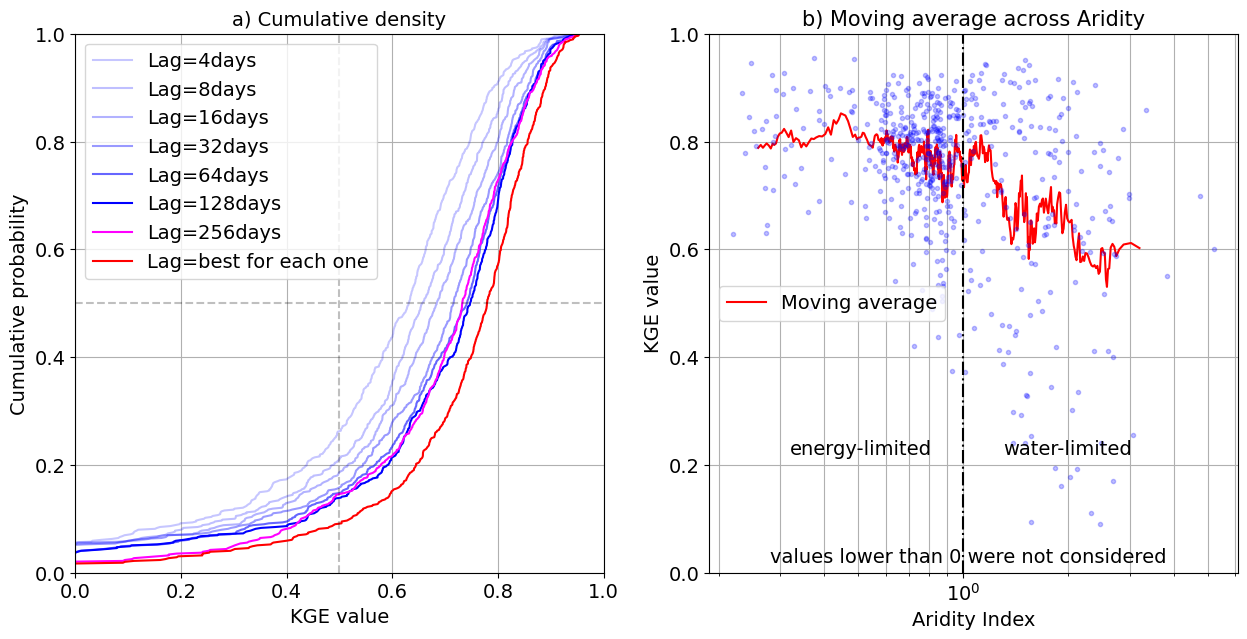

In [18]:
path = os.path.abspath(os.path.join(current_path, os.pardir)) + '/Notebooks/'
n_basins = len(df_list)
windows = 15

y = np.array(range(1,n_basins+1))
y = (y) / (n_basins*np.ones(n_basins))


KGE_sort1_LSTM = df_list['KGE_4']
KGE_sort1_LSTM = KGE_sort1_LSTM.sort_values(ascending=True)
KGE_sort2_LSTM = df_list['KGE_8']
KGE_sort2_LSTM = KGE_sort2_LSTM.sort_values(ascending=True)
KGE_sort3_LSTM = df_list['KGE_16']
KGE_sort3_LSTM = KGE_sort3_LSTM.sort_values(ascending=True)
KGE_sort4_LSTM = df_list['KGE_32']
KGE_sort4_LSTM = KGE_sort4_LSTM.sort_values(ascending=True)
KGE_sort5_LSTM = df_list['KGE_64']
KGE_sort5_LSTM = KGE_sort5_LSTM.sort_values(ascending=True)
KGE_sort6_LSTM = df_list['KGE_128']
KGE_sort6_LSTM = KGE_sort6_LSTM.sort_values(ascending=True)
KGE_sort7_LSTM = df_list['KGE_256']
KGE_sort7_LSTM = KGE_sort7_LSTM.sort_values(ascending=True)
KGE_sort8_LSTM = df_list['KGE_best']
KGE_sort8_LSTM = KGE_sort8_LSTM.sort_values(ascending=True)

plt.figure(figsize=(15,7))
plt.rcParams['font.size'] = '14'

plt.subplot(1,2,1)
plt.plot(KGE_sort1_LSTM, y, color="blue",label='Lag=4days',alpha=0.225)
plt.plot(KGE_sort2_LSTM, y, color="blue",label='Lag=8days',alpha=0.25)
plt.plot(KGE_sort3_LSTM, y, color="blue",label='Lag=16days',alpha=0.3)
plt.plot(KGE_sort4_LSTM, y, color="blue",label='Lag=32days',alpha=0.4)
plt.plot(KGE_sort5_LSTM, y, color="blue",label='Lag=64days',alpha=0.6)
plt.plot(KGE_sort6_LSTM, y, color="blue",label='Lag=128days',alpha=1)
plt.plot(KGE_sort7_LSTM, y, color="fuchsia", label='Lag=256days',alpha=1)
plt.plot(KGE_sort8_LSTM, y, color="red", label='Lag=best for each one',alpha=1)
plt.plot([0, 1], [0.5, 0.5], '--k', alpha=0.25)
plt.plot([0.5, 0.5], [0, 1], '--k', alpha=0.25)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.title('a) Cumulative density',fontsize=14)
plt.xlabel('KGE value',fontsize=14)
plt.ylabel('Cumulative probability',fontsize=14)
plt.legend()

attr_path = path + '/' + 'camels_clim.txt'
attr = pd.read_csv(attr_path, sep=';')
attr['gauge_id'] = attr['gauge_id'].apply(str)
attr.set_index('gauge_id',inplace=True)
df_list['aridity'] = attr.aridity


attr_path = path + '/' + 'camels_soil.txt'
attr = pd.read_csv(attr_path, sep=';')
attr['gauge_id'] = attr['gauge_id'].apply(str)
attr.set_index('gauge_id',inplace=True)
df_list['sand_frac'] = attr.sand_frac
df_list['K'] = attr.soil_conductivity
df_list['soil_depth'] = attr.soil_depth_statsgo


attr_path = path + '/' + 'camels_topo.txt'
attr = pd.read_csv(attr_path, sep=';')
attr['gauge_id'] = attr['gauge_id'].apply(str)
attr.set_index('gauge_id',inplace=True)
df_list['area'] = attr.area_gages2
df_list['slope'] = attr.slope_mean
df_list['Lat'] = attr.gauge_lat
df_list['Long'] = attr.gauge_lon


attr_path = path + '/' + 'camels_hydro.txt'
attr = pd.read_csv(attr_path, sep=';')
attr['gauge_id'] = attr['gauge_id'].apply(str)
attr.set_index('gauge_id',inplace=True)
df_list['baseflow_index'] = attr.baseflow_index

attr_path = path + '/' + 'camels_vege.txt'
attr = pd.read_csv(attr_path, sep=';')
attr['gauge_id'] = attr['gauge_id'].apply(str)
attr.set_index('gauge_id',inplace=True)
df_list['frac_forest'] = attr.frac_forest


plt.subplot(1,2,2)

x = df_list.aridity[df_list.KGE_best > 0]
y = df_list.KGE_best[df_list.KGE_best > 0]

x_sort = x.sort_values(ascending=True)
y_sort = y[x_sort.index]
plt.plot(x_sort.rolling(window=windows).mean(),y_sort.rolling(window=windows).mean(), 'r', label='Moving average')
plt.plot(x_sort,y_sort, 'b.', alpha = 0.25)

plt.plot([1,1],[-1,1],'-.k')
plt.text(0.32,0.22,'energy-limited')
plt.text(1.3,0.22,'water-limited')
plt.text(0.28, 0.02,'values lower than 0 were not considered')
plt.grid(which='both')
plt.xlabel('Aridity Index',fontsize=14)
plt.ylabel('KGE value',fontsize=14)
plt.title('b) Moving average across Aridity',fontsize=15)

plt.ylim(0,1)
plt.xscale('log')
plt.legend(loc=6)

plt.savefig('Fig6.jpg',  bbox_inches="tight")


# Fig 7 Spatial distribution of the best Lag

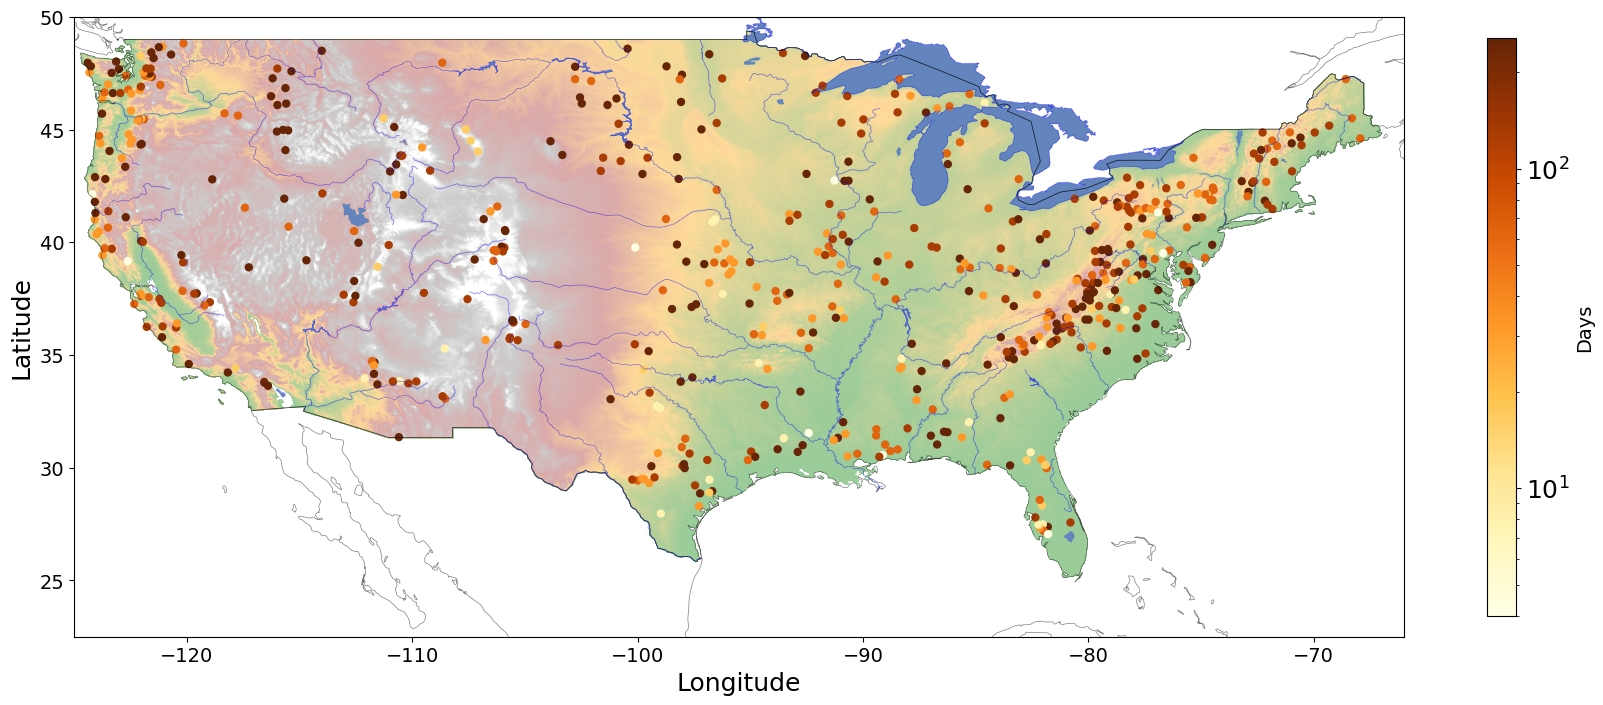

In [19]:
KGE_lim = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(21.45, 10))
plt.rcParams['font.size'] = '18'
df_continent.boundary.plot(color='black', ax=ax, lw=0.5,alpha=0.5)
df_drainage_network.plot(color='blue', ax=ax, lw=0.5, alpha=0.5)
df_lakes.plot(color='blue', ax=ax,lw=0.5, alpha=0.35)
ax.set_xlabel('Longitude',fontsize=18)
ax.set_ylabel('Latitude',fontsize=18)
ax.set_xlim([-125,-66])
ax.set_ylim([22.5,50])
#ax.set_title('Best Lag memory', fontsize=18)

cvals  = [-11, 0, 500, 1000, 2000,3000]
colors = ["white","green","orange","brown", "gray","white"]
norm_blue=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm_blue,cvals), colors))
cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

fp = current_path +'/elevation.tif'
img = rasterio.open(fp, 'r')
show((img, 1), ax=ax, cmap=cmap_blue, norm=norm_blue, alpha=0.4)

cm = plt.cm.get_cmap('YlOrBr')

sc = ax.scatter(df_list.Long[df_list.KGE_best>KGE_lim],df_list.Lat[df_list.KGE_best>KGE_lim],c=df_list.lag[df_list.KGE_best>KGE_lim],s=25,cmap=cm,norm=matplotlib.colors.LogNorm())

cbar = plt.colorbar(sc, shrink = 0.75)
cbar.set_label('Days', rotation=90, fontsize=14)

plt.savefig('Fig7.jpg',  bbox_inches="tight")